<a href="https://colab.research.google.com/github/nando-cezar/pandora/blob/developer/pandora_analytics.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

> EM-DAT will be used, which is a global database that records information about natural and technological disasters. It is maintained by the Disaster Epidemiology Research Center (CRED) at the Catholic University of Louvain, Belgium. EM-DAT provides data on the occurrence, impact and response to disasters since the beginning of the 20th century.

> Data analysis will be separated by category and continental regions, namely:

*   Dry
*   Flood
*   Extreme temperature
*   Mist
*   Storm







# Importing libraries


In [17]:
!pip3 install opencage

In [18]:
import pandas as pd
from google.colab import drive
from time import sleep
import warnings
import requests
import json
from pandas import json_normalize
import seaborn as sns
from google.colab import userdata
from opencage.geocoder import OpenCageGeocode


warnings.simplefilter("ignore")
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EM-DAT: Reading the file


> Restricting reading to the following columns: location, start date and end date.

In [14]:
df = pd.read_excel(f"{userdata.get('notebook_path')}/{userdata.get('file_path')}.xlsx", sheet_name=[0, "EM-DAT Data"], usecols='K, N, Z, AA, AB, AC, AD, AE')

# EM-DAT: File handling


> Performing row removal with NaN

In [15]:
_data_type = {'Country': str, 'Location': str, 'Start Year': int, 'Start Month': int, 'Start Day': int, 'End Year': int, 'End Month': int, 'End Day': int}
df = df['EM-DAT Data'].fillna(0).astype(_data_type)

## EM-DAT: Data visualization without processing

In [16]:
display(df)

Country  \
0   Bolivia (Plurinational State of)   
1                          Argentina   
2                            Uruguay   
3                              Chile   
4                             Brazil   
5                           Paraguay   
6                             Mexico   
7                          Argentina   
8   Bolivia (Plurinational State of)   
9                          Guatemala   
10                         Argentina   
11                             Chile   
12                            Mexico   
13                              Peru   
14                            Mexico   
15                         Argentina   
16                            Brazil   
17                             Chile   
18                              Peru   
19                          Paraguay   
20                           Uruguay   
21                            Mexico   
22                         Guatemala   
23                            Mexico   
24                       El Salvador   
25                              Peru   
26                         Argentina   
27  Bolivia (Plurinational State of)   
28                             Chile   
29                          Paraguay   
30                           Uruguay   
31                              Peru   
32                            Mexico   
33                              Peru   
34                         Guatemala   
35                              Peru   
36                              Peru   
37                              Peru   

                                             Location  Start Year  \
0            Cochabamba, Santa Cruz, La Paz provinces        2000   
1   Buenos Aires, Sante Fe, Formosa, Santa Cruz pr...        2000   
2                       Paysandu, Maldonado provinces        2000   
3   Antofagasta, Araucania, Arica y Painacota, Ata...        2000   
4   Porto Alegre district (Rio Grande Do Sul provi...        2000   
5   Alto Paraguay, Alto Parana, Amambay, Boqueron,...        2000   
6                                  Chihuahua province        2000   
7   Chubut, Neuquen, Rio Negro (Patagonia), Catama...        2001   
8         La Paz, Oruro, Cochabamba, Potosi provinces        2001   
9   El Progreso, Jalapa, Chiquimula, Zacapa, Jutia...        2001   
10  Catamarca, Chaco, Corrientes, Formosa, Jujuy, ...        2002   
11  Aisen del Gral. Carlos Ibañez del Campo, Antof...        2002   
12  Chihuahua, Sonora, Baja California, Baja Calif...        2002   
13  Ayacucho, Huancavelica, Tacna, Moquegua, Arequ...        2003   
14  Chihuahua, Puebla, Nuevo Leon, Hidalgo, Sonora...        2003   
15  Mar del Plata city (General Pueyrredon distric...        2004   
16                   Santa Catarina, Parana provinces        2004   
17  Aisen del Gral. Carlos Ibañez del Campo, Antof...        2004   
18  Ancash, Puno, Cusco, Arequipa, Moquegua, Tacna...        2004   
19  Alto Paraguay, Alto Parana, Amambay, Boqueron,...        2004   
20                                Montevideo province        2004   
21                                 Chihuahua province        2004   
22  Alta Verapaz, Baja Verapaz, Chimaltenango, Chi...        2006   
23  Aguascalientes, Baja California, Baja Californ...        2006   
24        Santa Tecla district (La Libertad province)        2006   
25  Amazonas, Ancash, Apurimac, Arequipa, Ayacucho...        2009   
26  Buenos Aires, Buenos Aires D.f., Catamarca, Ch...        2010   
27                                Santa Cruz province        2010   
28   Aisen del Gral. Carlos Ibañez del Campo province        2010   
29  Alto Paraguay, Alto Parana, Amambay, Boqueron,...        2010   
30  Artigas, Canelones, Cerro Largo, Colonia, Dura...        2010   
31  Ancash, Apurimac, Arequipa, Ayacucho, Cusco, H...        2010   
32              Sinaloa, Sonora, Tamaulipas provinces        2011   
33  Huancavelica, Cusco, Ayacucho, Arequipa, Moque...        2011   
34  Huehuetenango, Quiche, San Marcos, Solola, Que...

# Treatment: Algorithms for data processing and structure assembly

> Algorithm for processing data (Removing sentences within parentheses)

In [5]:
def ignore_surrounded_text(text, char_opening, char_closure):
    if char_opening not in text or char_closure not in text:
        return text

    stack = []
    new_text = []

    for c in text:
        if c == char_opening:
            stack.append(c)
        elif c == char_closure:
            if stack:
                stack.pop()
            else:
                raise ValueError('Unbalanced fencing')
        elif not stack:
            new_text.append(c)

    if stack:
        raise ValueError('Unbalanced fencing')

    return ''.join(new_text)

> Algorithm for processing data (Formatting date for the api model)



In [6]:
def date_format_API(date):
  return "-".join([str(int(item)).zfill(2) if isinstance(item, float) else str(item).zfill(2) for item in date])

> Algorithm for boxplot graph plating

In [7]:
def generate_bsplot(dataTable, title, xlabel, ylabel="Monitoring variables", width=20, heigth=5, boxplot_width=.4, stripplot_size=3):

    ax = sns.boxplot(data=dataTable, width=boxplot_width, orient='h', color=".8", linewidth=1.5, medianprops={"color": "r", "linewidth": 1})
    ax = sns.stripplot(data=dataTable, orient='h', size=stripplot_size)
    ax.figure.set_size_inches(width, heigth)

    ax.set_title(title, fontsize=15)
    ax.set_xlabel(f"Range of values ({xlabel})", fontsize=12)
    ax.set_ylabel(ylabel, fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=45)
    ax.grid()
    ax

> Algorithm for switch value

In [8]:
def switch_value(source, offset, target):
    return target if source == offset else source

> Algorithm for locality accuracy

In [9]:
def get_index(target, source, label):
    for index, item in enumerate(source):
        if target.strip() in item.get(label, ''):
            return index
    return -1

# GEOCODE MAPS: Load latitude and longitude information from API

> TEST CODE

In [21]:
key = '2b1048a610214fc8b8594bbde08138a3'
geocoder = OpenCageGeocode(key)

query = u'Bosutska ulica 10, Trnje, Zagreb, Croatia'

# no need to URI encode query, module does that for you
results = geocoder.geocode(query)

print(json.loads(results))
print(u'%f;%f;%s;%s' % (results[0]['geometry']['lat'],
                        results[0]['geometry']['lng'],
                        results[0]['components']['country_code'],
                        results[0]['annotations']['timezone']['name']))

[{'annotations': {'DMS': {'lat': "45° 47' 48.95736'' N", 'lng': "15° 58' 54.81948'' E"}, 'MGRS': '33TWL7630771954', 'Maidenhead': 'JN75xt71tg', 'Mercator': {'x': 1779096.332, 'y': 5717223.035}, 'NUTS': {'NUTS0': {'code': 'HR'}, 'NUTS1': {'code': 'HR0'}, 'NUTS2': {'code': 'HR05'}, 'NUTS3': {'code': 'HR050'}}, 'OSM': {'edit_url': 'https://www.openstreetmap.org/edit?way=398295928#map=17/45.79693/15.98189', 'note_url': 'https://www.openstreetmap.org/note/new#map=17/45.79693/15.98189&layers=N', 'url': 'https://www.openstreetmap.org/?mlat=45.79693&mlon=15.98189#map=17/45.79693/15.98189'}, 'UN_M49': {'regions': {'EUROPE': '150', 'HR': '191', 'SOUTHERN_EUROPE': '039', 'WORLD': '001'}, 'statistical_groupings': ['MEDC']}, 'callingcode': 385, 'currency': {'alternate_symbols': [], 'decimal_mark': ',', 'html_entity': '€', 'iso_code': 'EUR', 'iso_numeric': '978', 'name': 'Euro', 'smallest_denomination': 1, 'subunit': 'Cent', 'subunit_to_unit': 100, 'symbol': '€', 'symbol_first': 0, 'thousands_separa

> Algorithm for processing data (Search latitude and longitude from location)

In [10]:
def search_location(data):
    params = {
	"q": data,
	"api_key": userdata.get('api_key_geocode')
    }
    response = requests.get(f"{userdata.get('api_url_geocode')}", params=params)
    return json.loads(response.content)

> Getting information and formatting dataframe


In [11]:
_locale_structure = []

def get_location_info(text_country, location):
    sleep(1.5)  # Waits 1.5 seconds to ensure the API is called at the allowed rate
    result = search_location(data=location)

    if result:
        index = get_index(target=text_country, source=result, label="display_name")

        if index > -1:
            location_info = {
                'Location': result[index]["display_name"],
                'Latitude': result[index]["lat"],
                'Longitude': result[index]["lon"]
            }
            return location_info

    return None

def process_location_info(infos):
    text_country = ignore_surrounded_text(infos['Country'], "(", ")")
    text_location = ignore_surrounded_text(infos['Location'], "(", ")")
    rdf = text_location.split(',')

    if rdf:
        for location in rdf:
            location_info = get_location_info(text_country, location)

            if location_info:
                date_info = {
                    'Start Date': [infos['Start Year'], infos['Start Month'], switch_value(infos['Start Day'], 0, 1)],
                    'End Date': [infos['End Year'], infos['End Month'], switch_value(infos['End Day'], 0, 30)]
                }
                location_info.update(date_info)
                _locale_structure.append(location_info)

for _, infos in df.iterrows():
    process_location_info(infos)


## GEOCODE MAPS: Data visualization without processing

In [12]:
_data_type = {'Location': str, 'Latitude': str, 'Longitude': str, 'Start Date': object, 'End Date': object}
df = pd.DataFrame(_locale_structure).astype(_data_type)
display(df)

Location             Latitude  \
0    Cochabamba, Villa Coronilla, Cochabamba, Cerca...  -17.401245799999998   
1                                  Santa Cruz, Bolivia           -17.333333   
2    Buenos Aires, Comuna 1, Autonomous City of Bue...          -34.6037002   
3    Sante Fe, 250 Viviendas B, 118 Viviendas, Univ...          -39.0209899   
4                                   Formosa, Argentina          -24.5955306   
..                                                 ...                  ...   
284                                     Moquegua, Peru           -16.833333   
285                                        Pasco, Peru                -10.5   
286                                         Puno, Peru                  -15   
287                                        Tacna, Peru           -17.666667   
288  Oxígeno & Extintores Ayucucho, Jirón Cesar Val...          -13.1571849   

           Longitude     Start Date       End Date  
0    -66.16756808852   [2000, 7, 1]  [2000, 7, 30]  
1              -61.5   [2000, 7, 1]  [2000, 7, 30]  
2        -58.3815153  [2000, 6, 17]  [2000, 6, 17]  
3        -67.5588859  [2000, 6, 17]  [2000, 6, 17]  
4        -60.4289718  [2000, 6, 17]  [2000, 6, 17]  
..               ...            ...            ...  
284       -70.916667   [2015, 5, 1]  [2015, 9, 30]  
285           -75.25   [2015, 5, 1]  [2015, 9, 30]  
286              -70   [2015, 5, 1]  [2015, 9, 30]  
287       -70.333333   [2015, 5, 1]  [2015, 9, 30]  
288      -74.2183383   [2015, 5, 1]  [2015, 9, 30]  

[289 rows x 5 columns]

#OPEN-METEO: Load weather information from API



> Algorithm for processing data (Search weather from latitude and longitude) - 7days before to current date


In [ ]:
def search_info_weather(latitude, longitude, start_date, end_date):
    start_date = date_format_API(date=start_date)
    end_date = date_format_API(date=end_date)
    params = {
	"latitude": latitude,
	"longitude": longitude,
	"start_date": start_date,
	"end_date": end_date,
	"daily": "temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,wind_speed_10m_max,wind_gusts_10m_max,wind_direction_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration",
    "timezone": "GMT"
    }
    request = requests.get(f"{userdata.get('api_url_openmeteo')}", params=params)
    return json.loads(request.content)

> Getting information

In [ ]:
_weather_structure = []
for i, infos in df.iterrows():
  sleep(1)
  _info = search_info_weather(
      latitude=infos['Latitude'],
      longitude=infos['Longitude'],
      start_date=infos['Start Date'],
      end_date=infos['End Date']
      )
  _weather_structure.append(_info)

##OPEN-METEO: Data visualization without processing

In [ ]:
df = pd.DataFrame(_weather_structure)
display(df)

latitude  longitude  generationtime_ms  utc_offset_seconds timezone  \
0   -17.398947 -66.219880           1.221895                   0      GMT   
1   -17.328648 -61.474000           1.111031                   0      GMT   
2   -34.622143 -58.409090           0.303984                   0      GMT   
3   -39.050970 -67.530850           0.316024                   0      GMT   
4   -24.569420 -60.449220           0.352979                   0      GMT   
..         ...        ...                ...                 ...      ...   
284 -16.836555 -70.966490           4.456997                   0      GMT   
285 -10.509666 -75.251100           3.623009                   0      GMT   
286 -15.008787 -70.084015           4.198909                   0      GMT   
287 -17.680141 -70.309784           4.240990                   0      GMT   
288 -13.181019 -74.247955           4.215002                   0      GMT   

    timezone_abbreviation  elevation  \
0                     GMT     2552.0   
1                     GMT      252.0   
2                     GMT       18.0   
3                     GMT      241.0   
4                     GMT      131.0   
..                    ...        ...   
284                   GMT     2292.0   
285                   GMT     1605.0   
286                   GMT     3894.0   
287                   GMT     1600.0   
288                   GMT     2748.0   

                                           daily_units  \
0    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
1    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
2    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
3    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
4    {'time': 'iso8601', 'temperature_2m_max': '°C'...   
..                                                 ...   
284  {'time': 'iso8601', 'temperature_2m_max': '°C'...   
285  {'time': 'iso8601', 'temperature_2m_max': '°C'...   
286  {'time': 'iso8601', 'temperature_2m_max': '°C'...   
287  {'time': 'iso8601', 'temperature_2m_max': '°C'...   
288  {'time': 'iso8601', 'temperature_2m_max': '°C'...   

                                                 daily  
0    {'time': ['2000-07-01', '2000-07-02', '2000-07...  
1    {'time': ['2000-07-01', '2000-07-02', '2000-07...  
2    {'time': ['2000-06-17'], 'temperature_2m_max':...  
3    {'time': ['2000-06-17'], 'temperature_2m_max':...  
4    {'time': ['2000-06-17'], 'temperature_2m_max':...  
..                                                 ...  
284  {'time': ['2015-05-01', '2015-05-02', '2015-05...  
285  {'time': ['2015-05-01', '2015-05-02', '2015-05...  
286  {'time': ['2015-05-01', '2015-05-02', '2015-05...  
287  {'time': ['2015-05-01', '2015-05-02', '2015-05...  
288  {'time': ['2015-05-01', '2015-05-02', '2015-05...  

[289 rows x 9 columns]

##OPEN-METEO: Data visualization of daily information

In [ ]:
df = (
    json_normalize(df['daily'])
    .assign(latitude=df['latitude'], longitude=df['longitude'])
).drop(["sunrise", "sunset"], axis = 1)
display(df)

time  \
0    [2000-07-01, 2000-07-02, 2000-07-03, 2000-07-0...   
1    [2000-07-01, 2000-07-02, 2000-07-03, 2000-07-0...   
2                                         [2000-06-17]   
3                                         [2000-06-17]   
4                                         [2000-06-17]   
..                                                 ...   
284  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   
285  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   
286  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   
287  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   
288  [2015-05-01, 2015-05-02, 2015-05-03, 2015-05-0...   

                                    temperature_2m_max  \
0    [21.8, 21.7, 20.9, 20.1, 19.5, 21.1, 21.4, 20....   
1    [31.9, 30.6, 23.6, 26.8, 30.7, 30.4, 30.9, 30....   
2                                                [9.5]   
3                                                [5.0]   
4                                               [12.4]   
..                                                 ...   
284  [19.6, 19.5, 19.7, 19.7, 20.3, 21.4, 19.1, 20....   
285  [21.4, 22.5, 21.8, 20.8, 21.6, 22.5, 21.4, 22....   
286  [12.9, 13.7, 13.9, 14.0, 13.4, 14.4, 11.3, 13....   
287  [21.7, 21.8, 21.8, 22.1, 21.9, 22.6, 22.6, 21....   
288  [16.7, 18.7, 18.8, 18.6, 17.6, 17.8, 17.3, 16....   

                                    temperature_2m_min  \
0    [8.4, 4.7, 9.9, 8.5, 2.3, 1.9, 9.3, 5.2, 7.4, ...   
1    [24.5, 21.5, 18.1, 16.6, 16.7, 18.9, 21.1, 23....   
2                                                [3.9]   
3                                               [-3.2]   
4                                                [9.9]   
..                                                 ...   
284  [9.3, 8.5, 8.0, 4.7, 5.9, 11.8, 12.8, 8.8, 8.0...   
285  [16.2, 16.4, 17.0, 16.8, 16.1, 15.7, 16.2, 15....   
286  [3.8, 0.8, 2.6, 2.2, 1.9, 0.2, -0.4, 2.3, 2.8,...   
287  [14.9, 15.0, 14.4, 12.2, 14.7, 14.6, 16.3, 15....   
288  [11.2, 9.5, 7.9, 10.8, 10.7, 8.4, 9.5, 9.9, 9....   

                                   temperature_2m_mean  \
0    [14.4, 14.2, 14.7, 14.1, 12.1, 12.7, 14.0, 13....   
1    [27.5, 26.0, 20.1, 21.1, 23.2, 24.5, 25.4, 26....   
2                                                [6.9]   
3                                                [0.5]   
4                                               [10.8]   
..                                                 ...   
284  [15.0, 14.2, 14.4, 12.5, 13.8, 16.1, 16.1, 15....   
285  [18.1, 18.6, 18.6, 18.1, 17.9, 18.3, 18.1, 17....   
286  [7.6, 6.6, 8.1, 8.4, 8.0, 7.7, 5.8, 6.7, 7.1, ...   
287  [17.7, 17.6, 17.4, 17.2, 17.8, 18.0, 18.7, 18....   
288  [13.5, 13.8, 13.3, 14.1, 13.4, 12.8, 13.1, 12....   

                              apparent_temperature_max  \
0    [20.0, 20.0, 19.3, 18.7, 17.8, 19.1, 18.8, 19....   
1    [31.2, 31.6, 23.2, 28.1, 32.0, 30.1, 28.6, 29....   
2                                                [5.7]   
3                                                [1.1]   
4                                                [9.4]   
..                                                 ...   
284  [20.1, 19.2, 18.9, 19.1, 19.7, 20.8, 18.8, 20....   
285  [23.4, 25.4, 24.5, 23.1, 25.1, 25.6, 23.9, 26....   
286  [11.4, 11.2, 12.0, 12.9, 11.4, 13.0, 8.8, 12.8...   
287  [21.7, 21.3, 21.6, 21.2, 20.9, 21.5, 21.1, 21....   
288  [16.4, 18.8, 19.1, 19.1, 17.5, 17.6, 17.0, 16....   

                              apparent_temperature_min  \
0    [6.4, 2.3, 8.6, 6.0, -0.2, -0.7, 7.4, 3.0, 5.6...   
1    [25.7, 20.9, 15.9, 15.8, 18.2, 20.3, 21.3, 23....   
2                                                [0.3]   
3                                               [-7.1]   
4                                                [6.7]   
..                                                 ...   
284  [7.9, 6.2, 5.6, 1.5, 2.6, 9.1, 11.6, 6.9, 5.5,...   
285  [17.9, 17.9, 18.9, 18.9, 17.6, 17.0, 17.9, 16....   
286  [1.4, -2.2, 0.3, -0.6, -1.0, -3.0, -3.

##OPEN-METEO: Reorganization of daily information structure

In [ ]:
columns_to_explode = [
    'time',
    'temperature_2m_max',
    'temperature_2m_min',
    'temperature_2m_mean',
    'apparent_temperature_max',
    'apparent_temperature_min',
    'apparent_temperature_mean',
    'precipitation_sum',
    'rain_sum',
    'snowfall_sum',
    'precipitation_hours',
    'wind_speed_10m_max',
    'wind_gusts_10m_max',
    'wind_direction_10m_dominant',
    'shortwave_radiation_sum',
    'et0_fao_evapotranspiration',
]

df = df.explode(columns_to_explode)


##OPEN-METEO: Data visualization daily information

In [ ]:
_data_type = {
    'time': object,
    'temperature_2m_max': float,
    'temperature_2m_min': float,
    'temperature_2m_mean': float,
    'apparent_temperature_max': float,
    'apparent_temperature_min': float,
    'apparent_temperature_mean': float,
    'precipitation_sum': float,
    'rain_sum': float,
    'snowfall_sum': float,
    'precipitation_hours': float,
    'wind_speed_10m_max': float,
    'wind_gusts_10m_max': float,
    'wind_direction_10m_dominant': float,
    'shortwave_radiation_sum': float,
    'et0_fao_evapotranspiration': float,
    'latitude': str,
    'longitude': str
}

df = df.astype(_data_type)
display(df)

time  temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
0    2000-07-01                21.8                 8.4                 14.4   
0    2000-07-02                21.7                 4.7                 14.2   
0    2000-07-03                20.9                 9.9                 14.7   
0    2000-07-04                20.1                 8.5                 14.1   
0    2000-07-05                19.5                 2.3                 12.1   
..          ...                 ...                 ...                  ...   
288  2015-09-26                18.9                11.1                 14.3   
288  2015-09-27                19.8                10.0                 14.6   
288  2015-09-28                19.1                10.6                 13.8   
288  2015-09-29                19.0                 9.3                 13.4   
288  2015-09-30                18.4                10.7                 13.7   

     apparent_temperature_max  apparent_temperature_min  \
0                        20.0                       6.4   
0                        20.0                       2.3   
0                        19.3                       8.6   
0                        18.7                       6.0   
0                        17.8                      -0.2   
..                        ...                       ...   
288                      18.4                      10.6   
288                      20.2                       9.2   
288                      19.8                       9.9   
288                      19.1                       8.9   
288                      19.1                       9.9   

     apparent_temperature_mean  precipitation_sum  rain_sum  snowfall_sum  \
0                         12.4                0.0       0.0           0.0   
0                         11.9                0.0       0.0           0.0   
0                         12.8                0.0       0.0           0.0   
0                         11.7                0.0       0.0           0.0   
0                          9.9                0.0       0.0           0.0   
..                         ...                ...       ...           ...   
288                       13.6                2.3       2.3           0.0   
288                       13.9                1.7       1.7           0.0   
288                       13.1                2.4       2.4           0.0   
288                       12.8                1.0       1.0           0.0   
288                       13.0                1.9       1.9           0.0   

     precipitation_hours  wind_speed_10m_max  wind_gusts_10m_max  \
0                    0.0                13.3                38.2   
0                    0.0                10.5                26.3   
0                    0.0                11.6                34.6   
0                    0.0                 8.4                26.3   
0                    0.0                 7.6                21.2   
..                   ...                 ...                 ...   
288                  8.0                 6.7                23.0   
288                  3.0                 8.4                28.8   
288                  4.0                 7.6                26.6   
288                  4.0                10.2                31.3   
288                  5.0                 7.9                27.0   

     wind_direction_10m_dominant  shortwave_radiation_sum  \
0                          349.0                    18.96   
0                          355.0                    19.80   
0                          114.0                    18.75   
0                           92.0                    19.70   
0                           33.0                    19.50   
..                           ...                      ...   
288                         44.0                    17.39   
288                         46.0                    22.52   
288                         47.0                  

#Data analysis - Central Tendency Measures


## Mean

In [ ]:
_data = df.groupby(['time']).mean()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2000-06-17            8.966667            3.533333             6.066667   
2000-07-01           27.763158           17.278947            21.731579   
2000-07-02           25.410526           14.205263            20.326316   
2000-07-03           17.112000            8.716000            12.592000   
2000-07-04           21.947368            9.931579            15.042105   
...                        ...                 ...                  ...   
2015-09-26           20.430000           12.460000            15.870000   
2015-09-27           21.160000           10.890000            15.840000   
2015-09-28           21.220000           11.630000            15.920000   
2015-09-29           20.930000           10.610000            15.520000   
2015-09-30           20.490000           11.120000            15.410000   

            apparent_temperature_max  apparent_temperature_min  \
time                                                             
2000-06-17                  5.400000                 -0.033333   
2000-07-01                 28.594737                 17.131579   
2000-07-02                 25.547368                 12.257895   
2000-07-03                 14.420000                  5.624000   
2000-07-04                 22.731579                  7.684211   
...                              ...                       ...   
2015-09-26                 20.540000                 11.670000   
2015-09-27                 21.610000                  9.460000   
2015-09-28                 21.670000                 10.340000   
2015-09-29                 21.140000                  9.150000   
2015-09-30                 20.700000                  9.710000   

            apparent_temperature_mean  precipitation_sum   rain_sum  \
time                                                                  
2000-06-17                   2.533333           0.333333   0.333333   
2000-07-01                  22.042105           0.721053   0.721053   
2000-07-02                  19.484211          18.736842  18.736842   
2000-07-03                   9.940000           4.884000   4.844000   
2000-07-04                  13.900000           0.005263   0.005263   
...                               ...                ...        ...   
2015-09-26                  15.330000           4.010000   3.820000   
2015-09-27                  15.130000           3.610000   3.610000   
2015-09-28                  15.220000           3.310000   3.250000   
2015-09-29                  14.650000           2.120000   2.120000   
2015-09-30                  14.500000           3.550000   3.460000   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
time                                                                
2000-06-17         0.000             1.666667           15.300000   
2000-07-01         0.000             1.263158           22.721053   
2000-07-02         0.000             6.736842           26.389474   
2000-07-03         0.028             2.840000           18.216000   
2000-07-04         0.000             0.052632           11.942105   
...                  ...                  ...                 ...   
2015-09-26         0.133             8.000000           11.050000   
2015-09-27         0.000             5.200000           10.510000   
2015-09-28         0.042             5.700000           10.780000   
2015-09-29         0.000             3.700000           11.520000   
2015-09-30         0.063             5.400000           10.960000   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
time                                                          
2000-06-17           26.400000                   167.000000   
2000-07-01           47.084211                    64.315789   
2000-07-02           60.589474                   247.789474   
2000-07-03           38.624000          

### Data visualization with processing

> Temperature

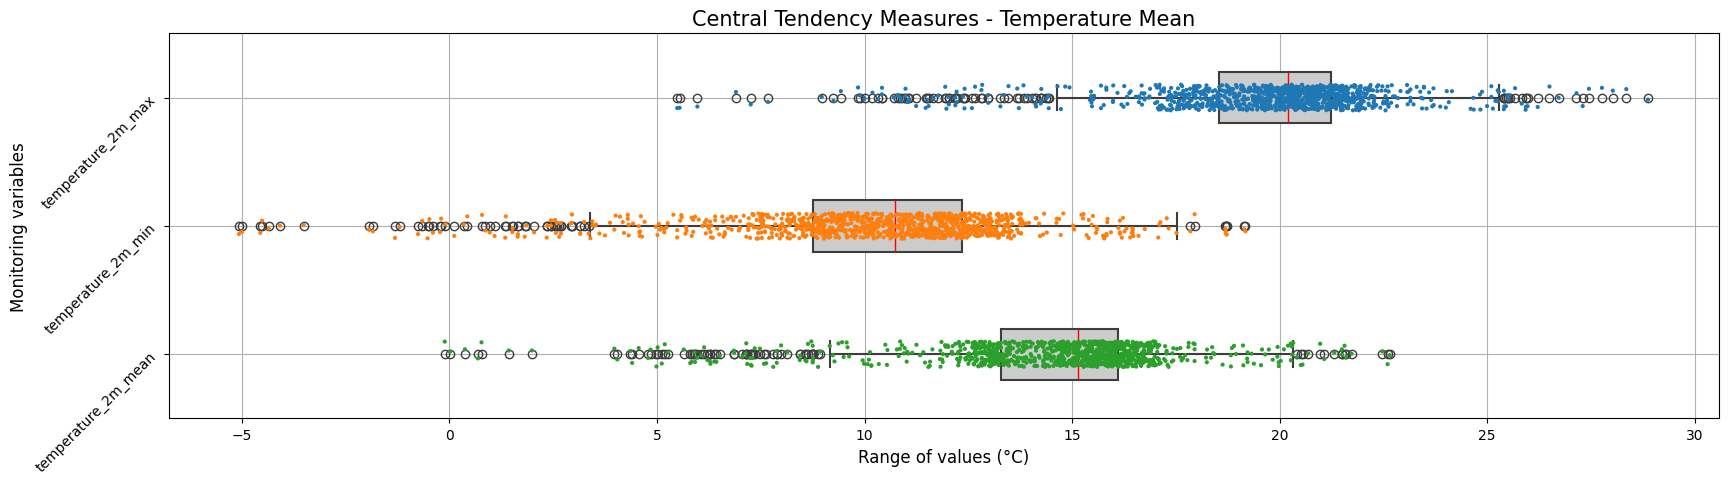

In [ ]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Mean",
    xlabel="°C"
    )

> Apparent Temperature

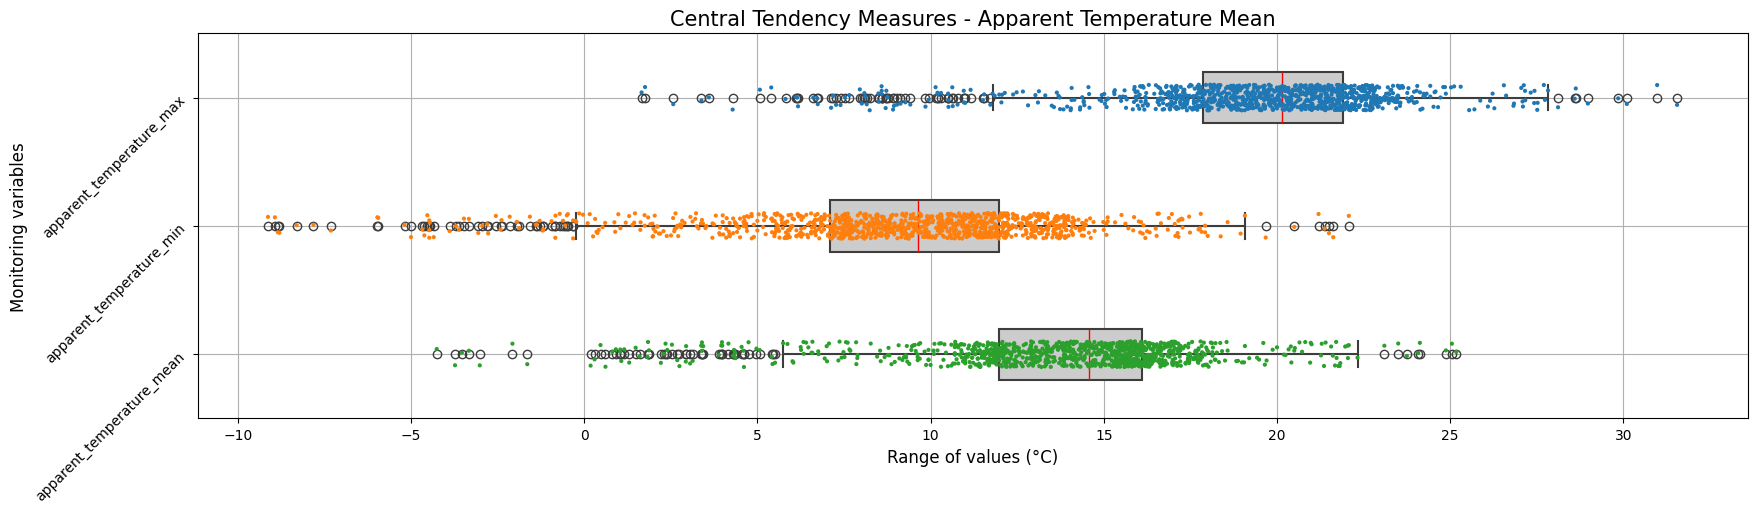

In [ ]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Mean",
    xlabel="°C"
    )

> Precipitation and rain

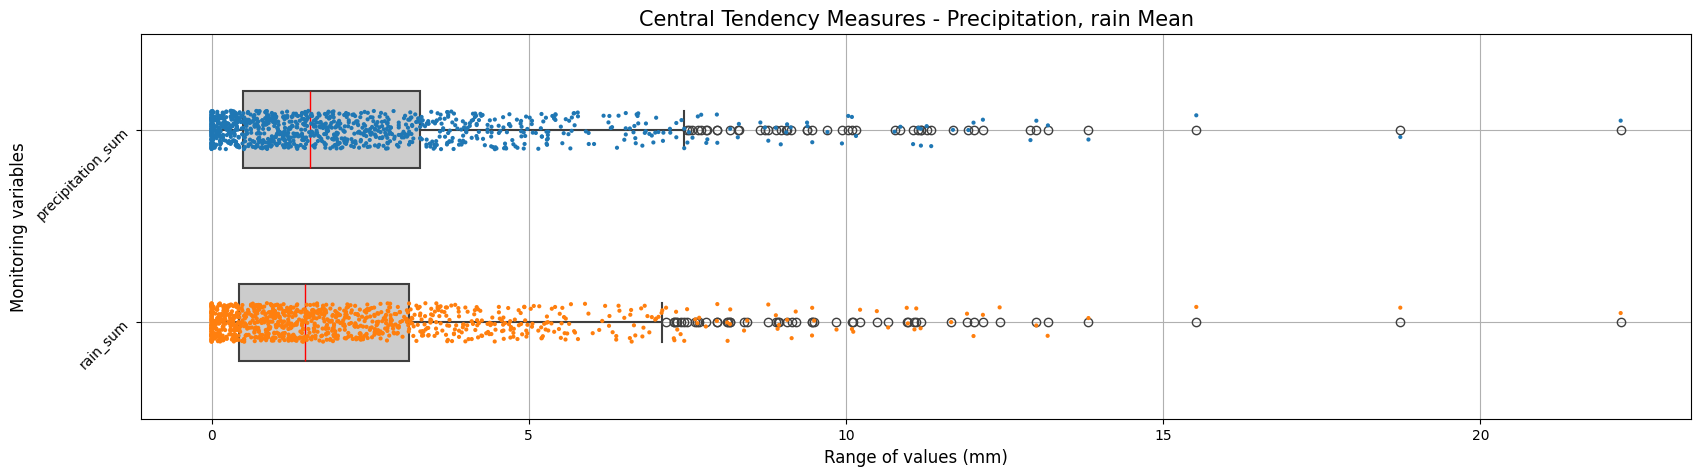

In [ ]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation, rain Mean",
    xlabel="mm"
    )

> Snowfall

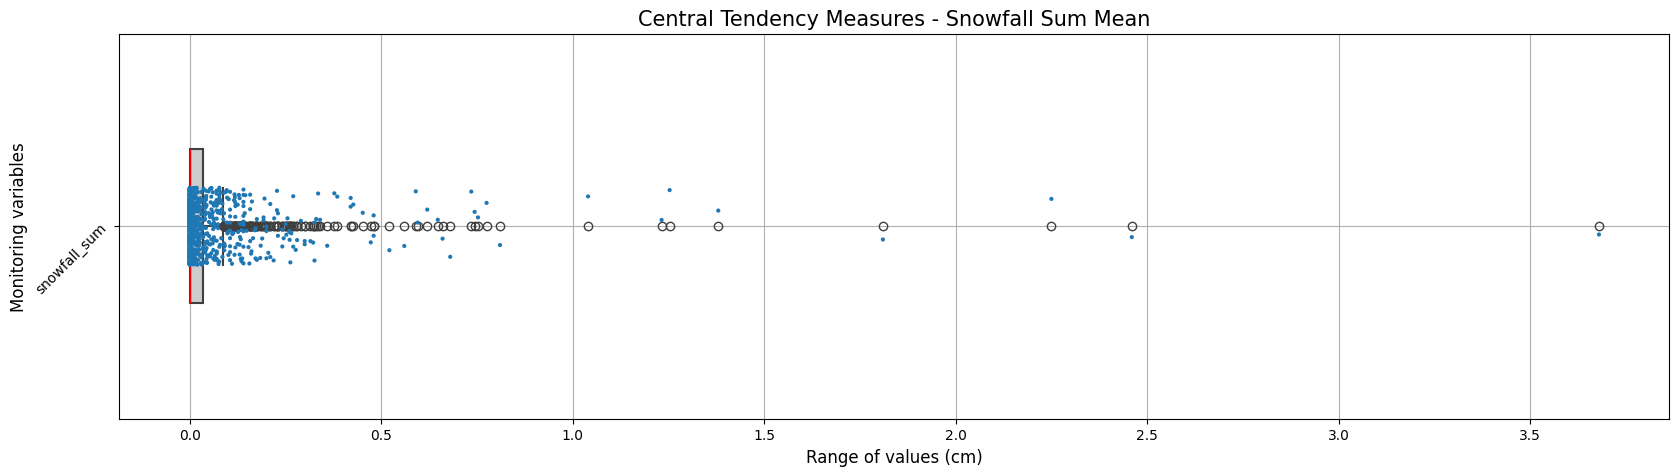

In [ ]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Mean",
    xlabel="cm"
    )

> Precipitation (h)

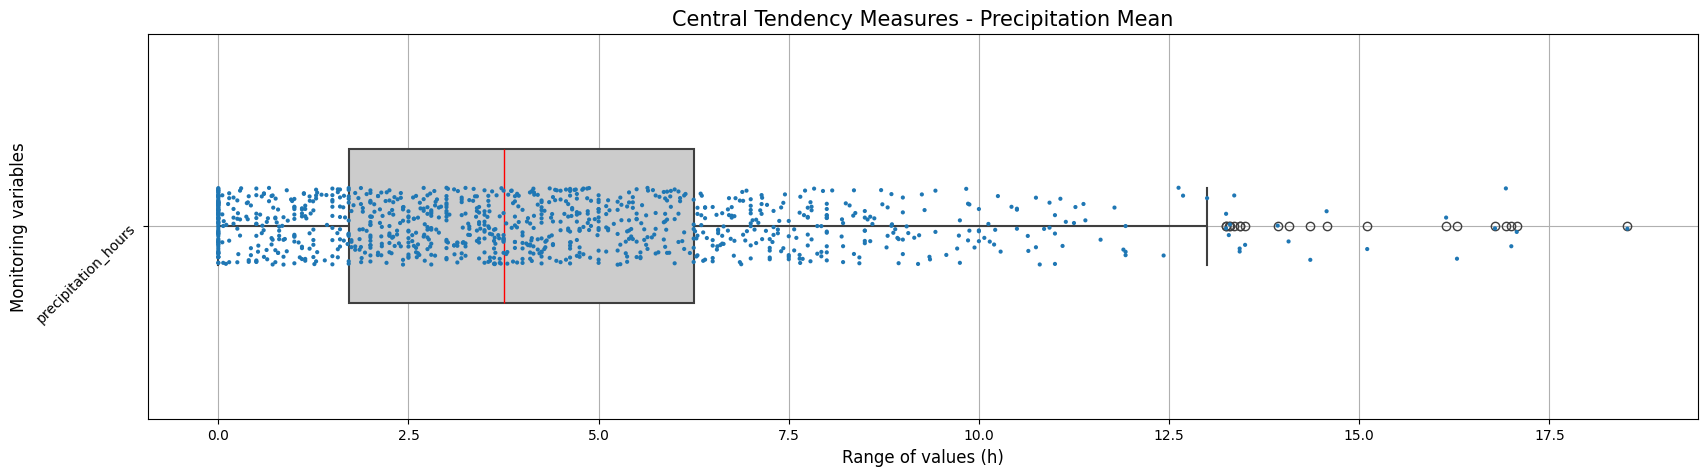

In [ ]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Mean",
    xlabel="h"
    )

> Wind speed 10m

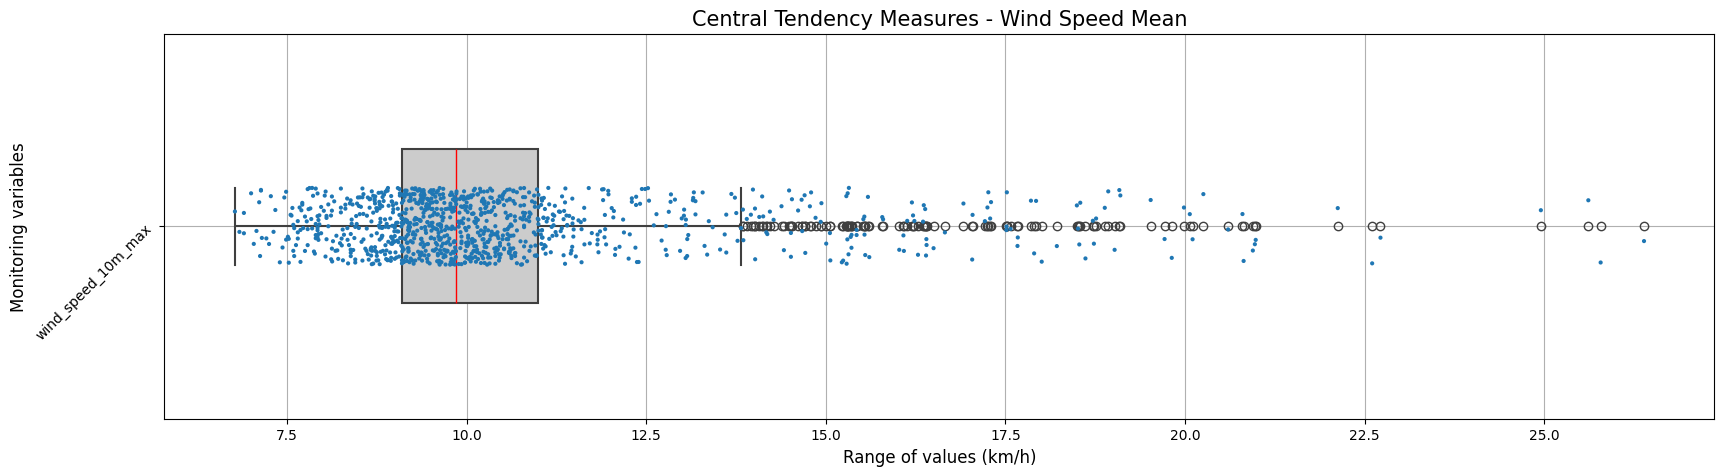

In [ ]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Mean",
    xlabel="km/h"
    )

> Wind direction 10m

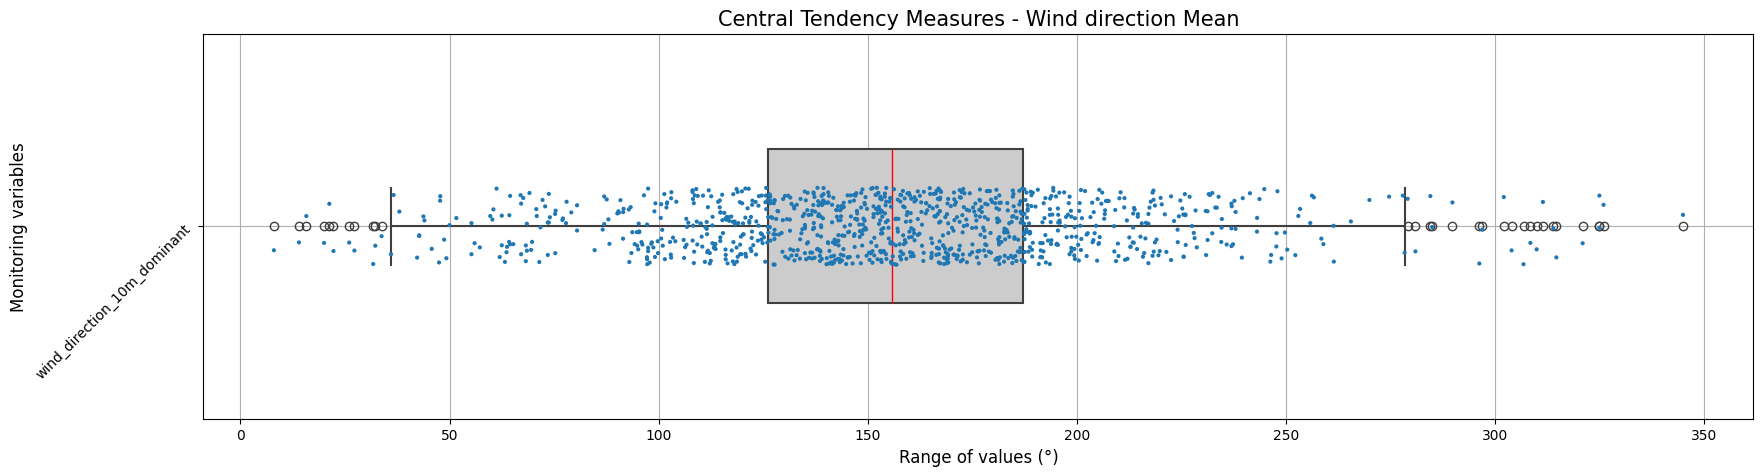

In [ ]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Mean",
    xlabel="°"
    )

> Shortware radiation sum

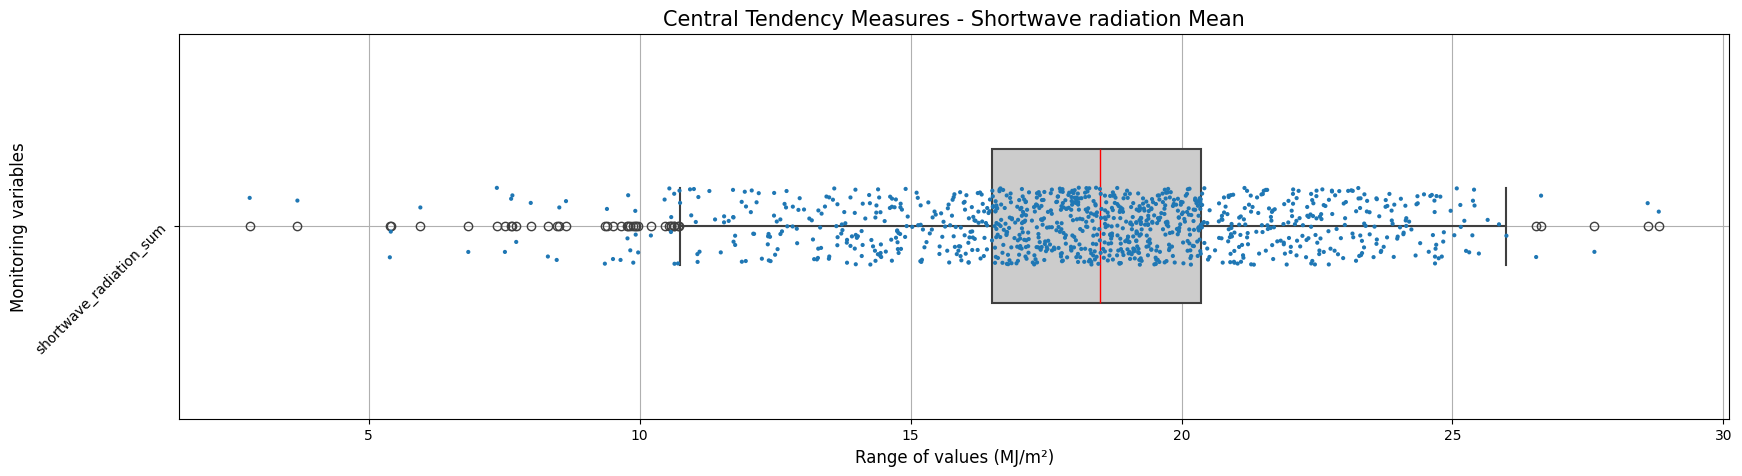

In [ ]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Mean",
    xlabel="MJ/m²"
    )

> Evapotranspiration

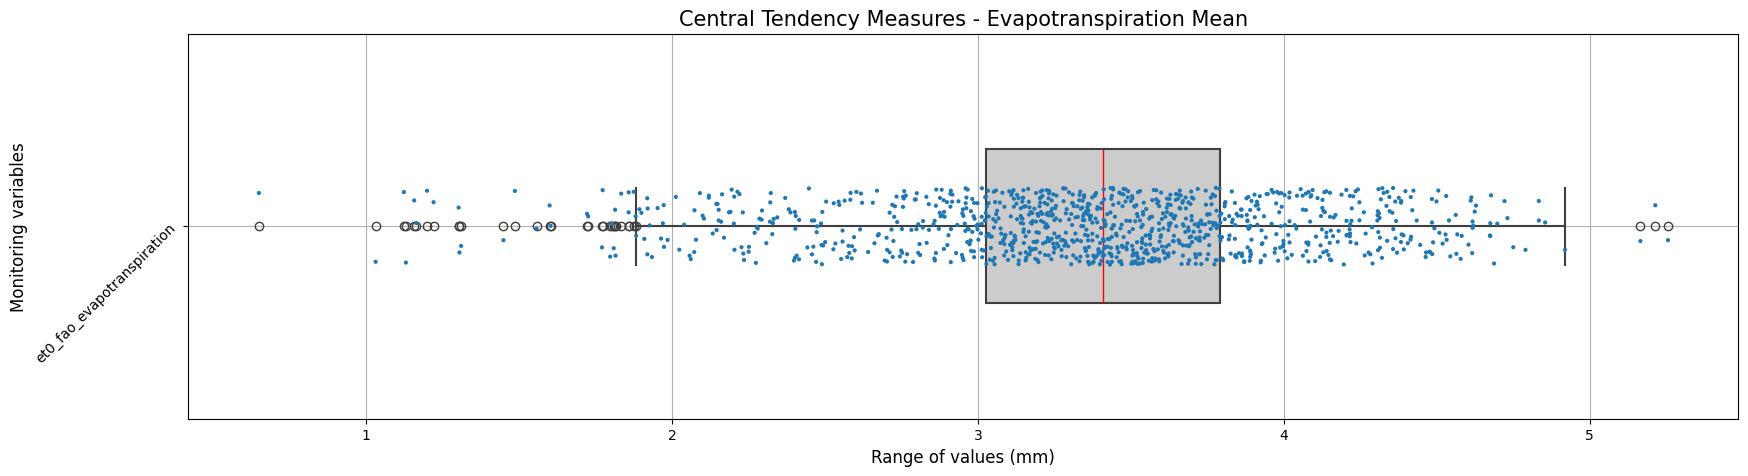

In [ ]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures - Evapotranspiration Mean",
    xlabel="mm"
    )

## Median

In [ ]:
_data = df.groupby(['time']).median()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2000-06-17                9.50                3.90                 6.90   
2000-07-01               28.20               16.30                21.60   
2000-07-02               25.60               13.90                20.20   
2000-07-03               17.30                8.00                12.10   
2000-07-04               21.90                8.70                14.10   
...                        ...                 ...                  ...   
2015-09-26               20.10               13.55                16.15   
2015-09-27               20.55               11.10                16.60   
2015-09-28               20.85               12.05                17.10   
2015-09-29               21.25               10.45                16.55   
2015-09-30               20.55               11.75                15.90   

            apparent_temperature_max  apparent_temperature_min  \
time                                                             
2000-06-17                      5.70                      0.30   
2000-07-01                     29.70                     15.90   
2000-07-02                     25.80                     11.90   
2000-07-03                     14.00                      5.10   
2000-07-04                     23.50                      6.00   
...                              ...                       ...   
2015-09-26                     20.00                     11.60   
2015-09-27                     20.65                      8.65   
2015-09-28                     21.55                     11.20   
2015-09-29                     21.00                      8.50   
2015-09-30                     21.55                      9.75   

            apparent_temperature_mean  precipitation_sum  rain_sum  \
time                                                                 
2000-06-17                       3.00               0.00      0.00   
2000-07-01                      22.00               0.00      0.00   
2000-07-02                      19.30              18.90     18.90   
2000-07-03                       9.10               0.00      0.00   
2000-07-04                      12.80               0.00      0.00   
...                               ...                ...       ...   
2015-09-26                      14.95               2.55      2.55   
2015-09-27                      14.95               0.65      0.65   
2015-09-28                      15.20               1.15      1.15   
2015-09-29                      14.85               0.20      0.20   
2015-09-30                      14.45               0.25      0.25   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
time                                                                
2000-06-17           0.0                  0.0               17.20   
2000-07-01           0.0                  0.0               23.60   
2000-07-02           0.0                  7.0               24.80   
2000-07-03           0.0                  0.0               17.50   
2000-07-04           0.0                  0.0               12.20   
...                  ...                  ...                 ...   
2015-09-26           0.0                  7.0               11.25   
2015-09-27           0.0                  2.5               10.70   
2015-09-28           0.0                  3.5               10.95   
2015-09-29           0.0                  1.5               12.20   
2015-09-30           0.0                  2.0               12.50   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
time                                                          
2000-06-17               29.20                        178.0   
2000-07-01               45.70                         32.0   
2000-07-02               62.60                        323.0   
2000-07-03               37.10                       

### Data visualization with processing

> Temperature

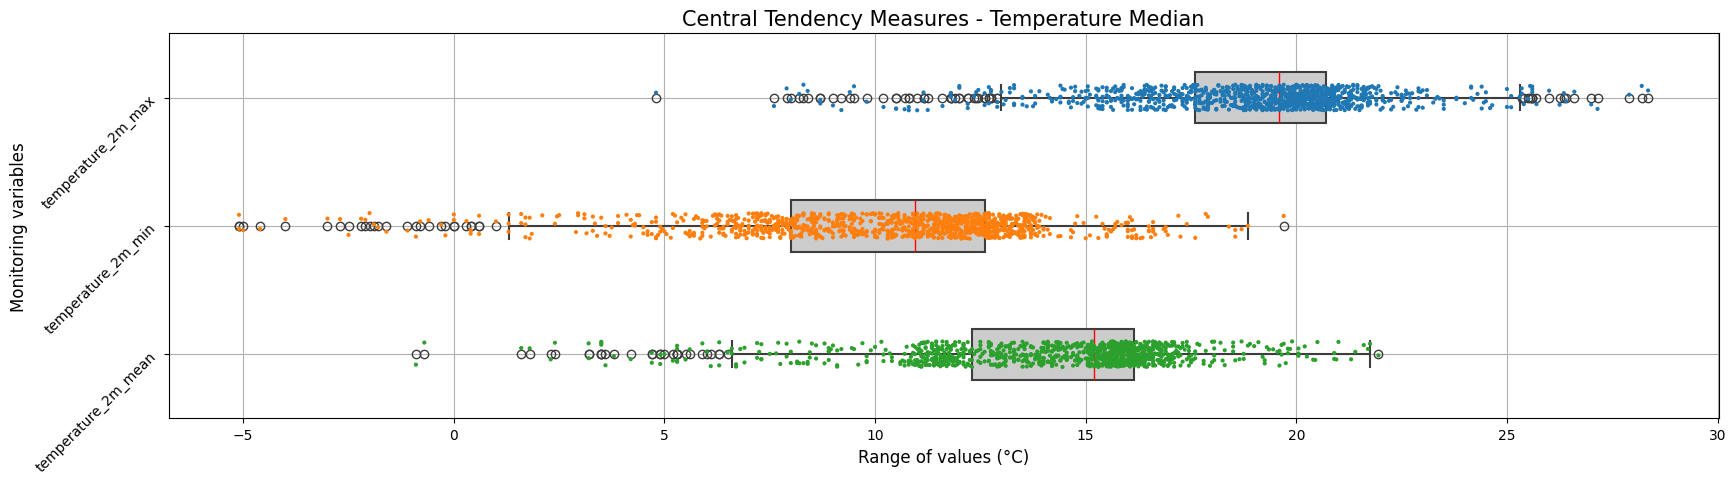

In [ ]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Median",
    xlabel="°C"
    )

> Apparent Temperature

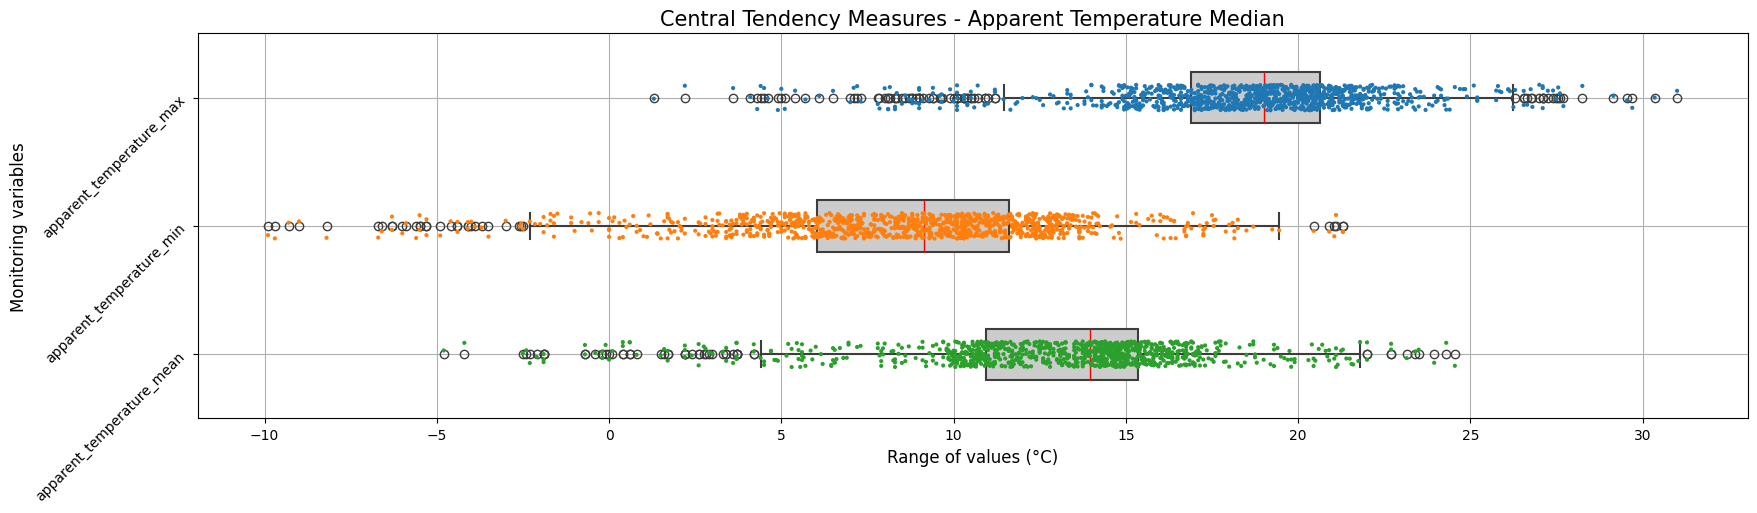

In [ ]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Median",
    xlabel="°C"
    )

> Precipitation and rain

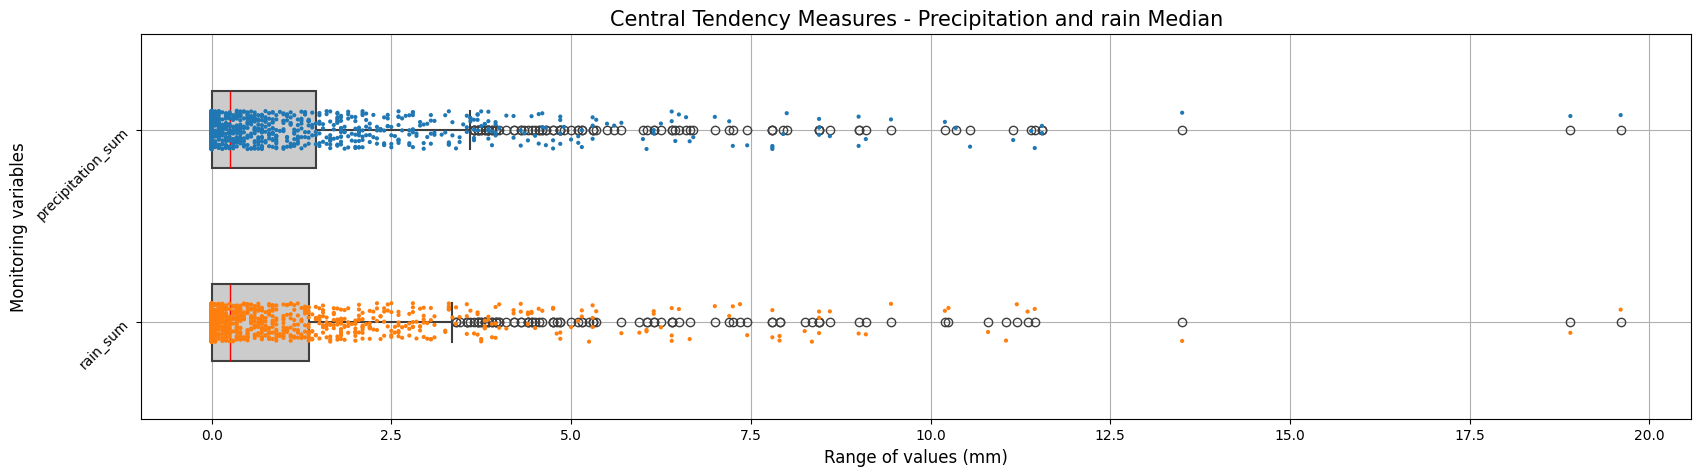

In [ ]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Median",
    xlabel="mm"
    )

> Snowfall

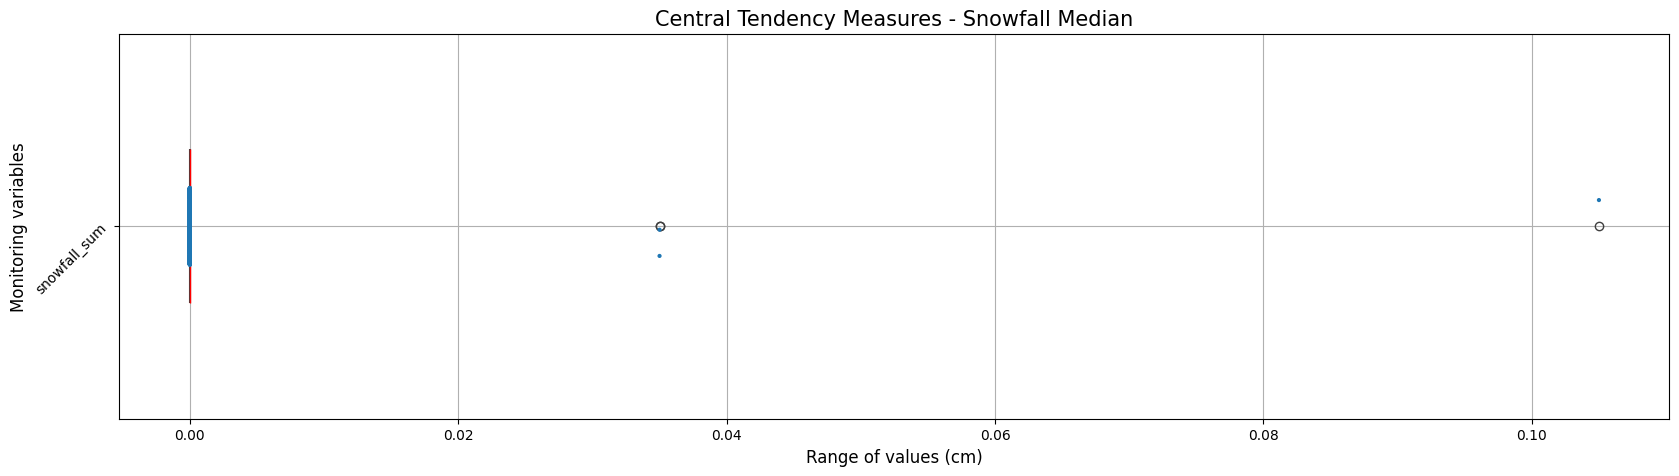

In [ ]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Median",
    xlabel="cm"
    )

> Precipitation (h)

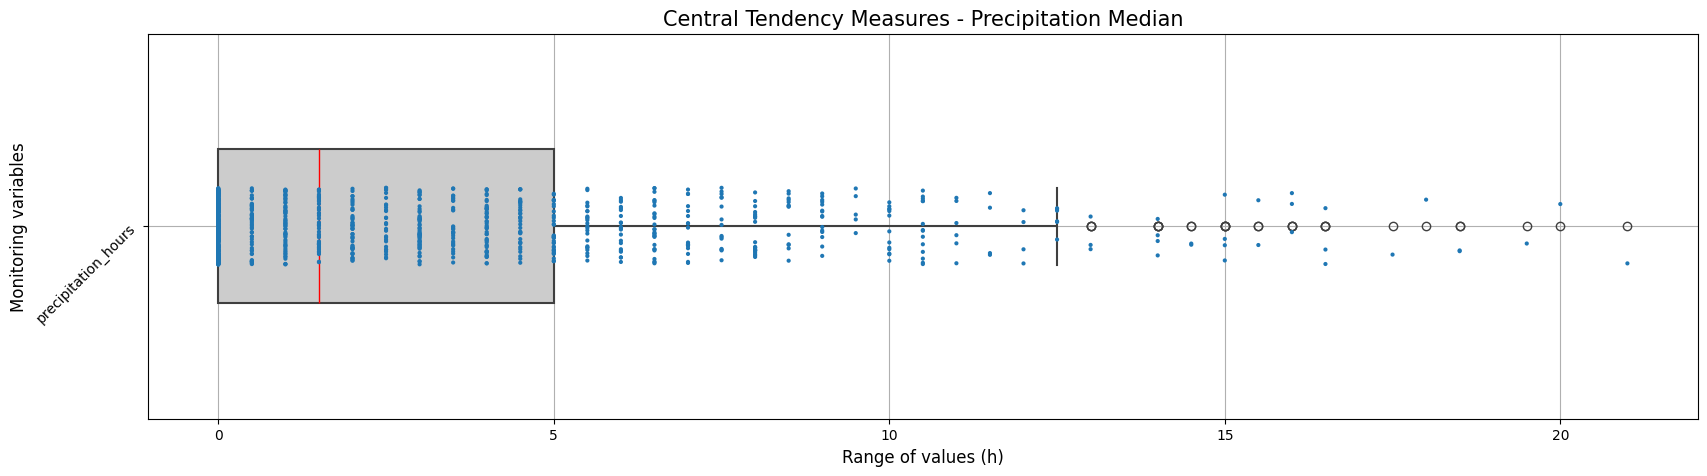

In [ ]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Median",
    xlabel="h"
    )

> Wind speed 10m

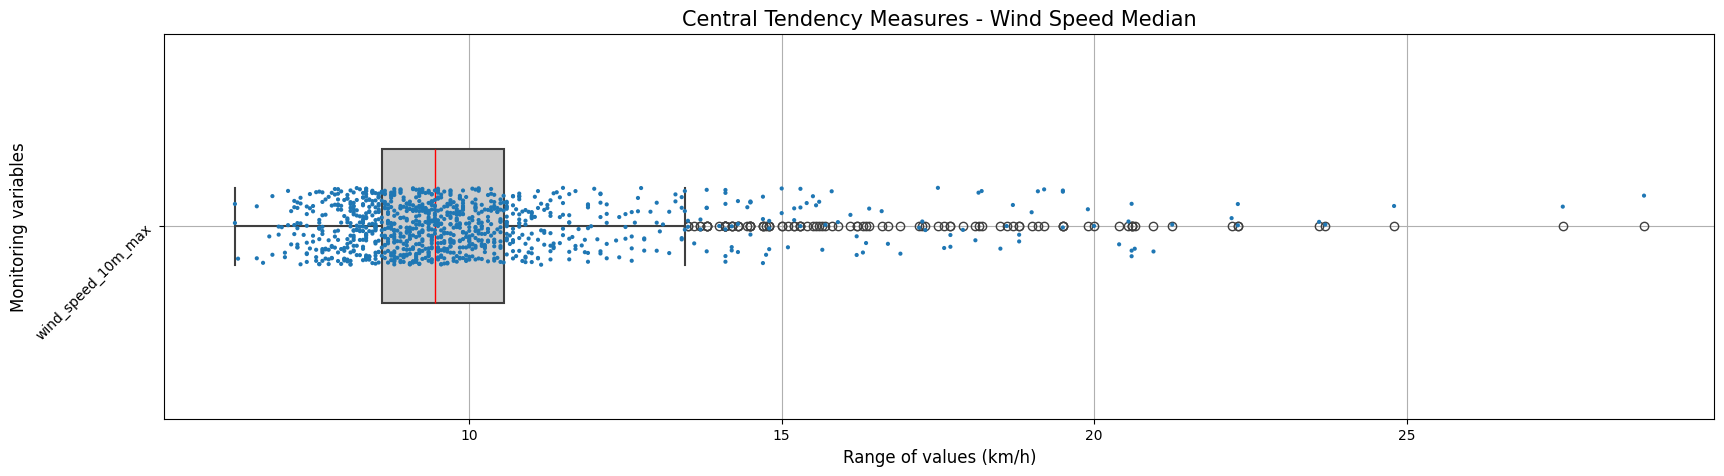

In [ ]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Median",
    xlabel="km/h"
    )

> Wind direction 10m

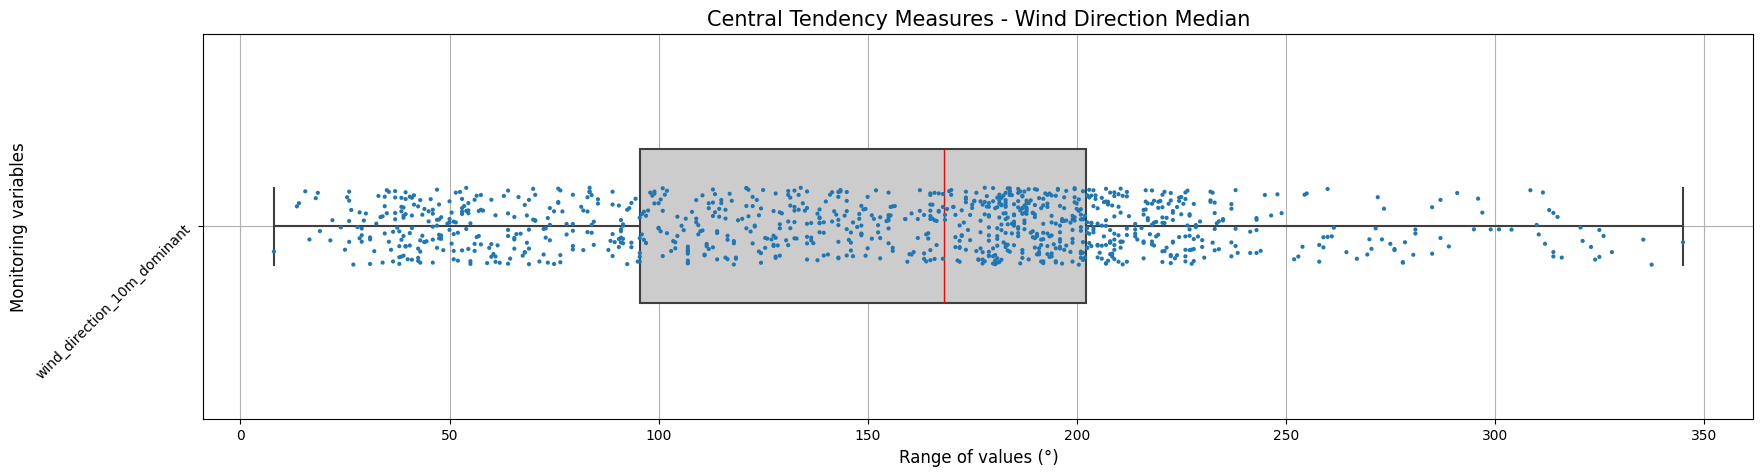

In [ ]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind Direction Median",
    xlabel="°"
    )

> Shortwave radiation sum

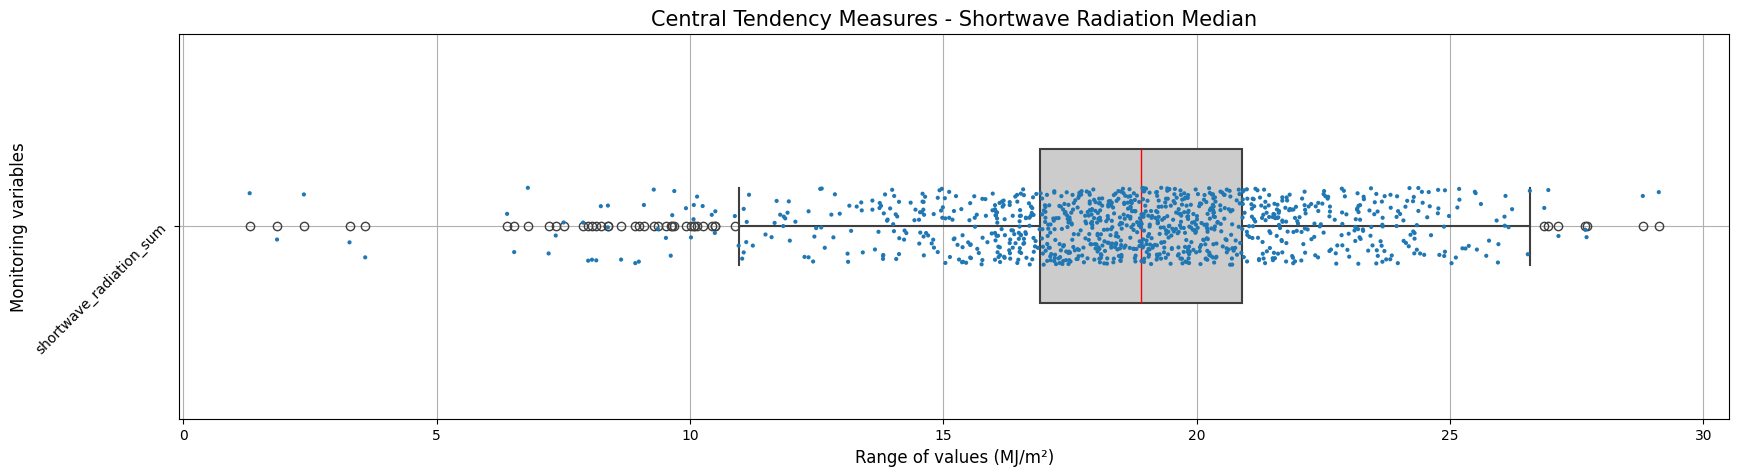

In [ ]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave Radiation Median",
    xlabel="MJ/m²"
    )

> Evapotranspiration

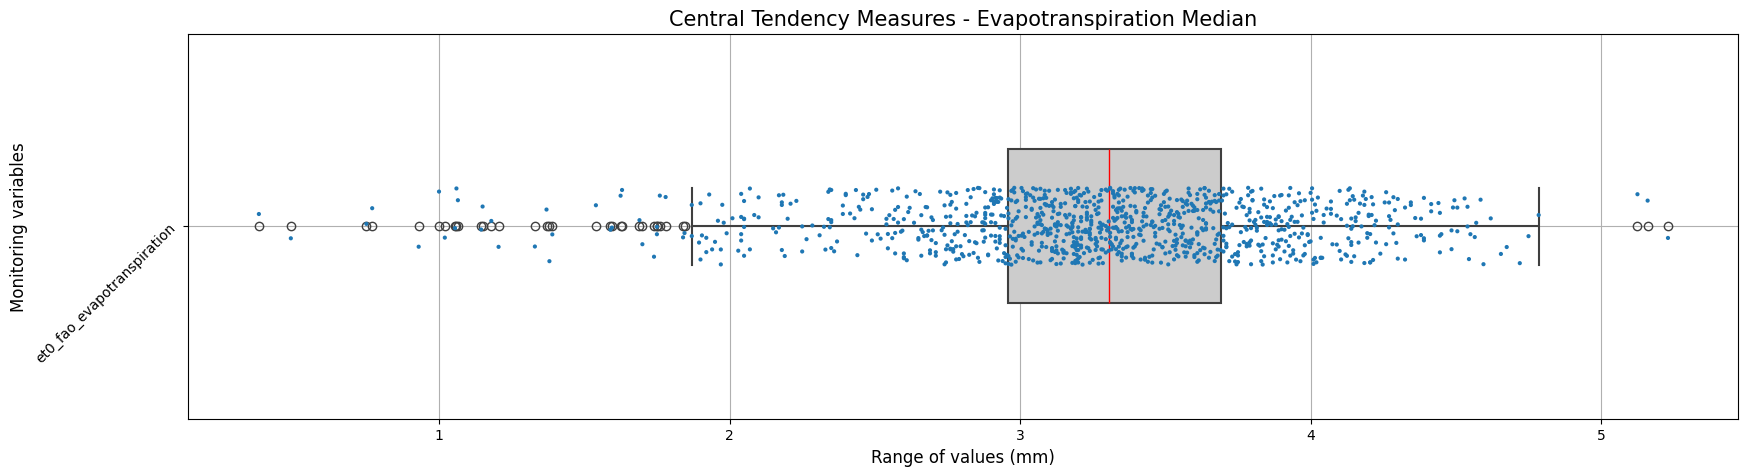

In [ ]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures - Evapotranspiration Median",
    xlabel="mm"
    )

# Data analysis - Dispersion Measures

## Variance

In [ ]:
_data = df.groupby(['time']).var()
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2000-06-17           13.903333           43.003333            27.043333   
2000-07-01           13.842456           21.460643            16.030058   
2000-07-02           13.143216           13.288304            11.612047   
2000-07-03           14.970267           15.115567            11.270767   
2000-07-04            5.914854           15.833392             8.863684   
...                        ...                 ...                  ...   
2015-09-26           63.751222           69.522667            66.231222   
2015-09-27           59.873778           74.292111            62.578222   
2015-09-28           69.632889           57.511222            61.415111   
2015-09-29           61.306778           64.483222            59.375111   
2015-09-30           57.794333           70.764000            60.256556   

            apparent_temperature_max  apparent_temperature_min  \
time                                                             
2000-06-17                 17.290000                 47.693333   
2000-07-01                 14.809415                 33.405614   
2000-07-02                 19.738187                 19.793684   
2000-07-03                 20.667500                 21.779400   
2000-07-04                 13.533392                 23.173626   
...                              ...                       ...   
2015-09-26                102.164889                 95.969000   
2015-09-27                 87.778778                 97.760444   
2015-09-28                 96.529000                 77.349333   
2015-09-29                 87.147111                 83.411667   
2015-09-30                 84.642222                 88.994333   

            apparent_temperature_mean  precipitation_sum    rain_sum  \
time                                                                   
2000-06-17                  30.413333           0.333333    0.333333   
2000-07-01                  22.622573           3.182865    3.182865   
2000-07-02                  20.894737          78.508012   78.508012   
2000-07-03                  17.789167         194.661400  192.541733   
2000-07-04                  15.323333           0.000526    0.000526   
...                               ...                ...         ...   
2015-09-26                  98.989000          30.309889   29.244000   
2015-09-27                  90.197889          43.718778   43.718778   
2015-09-28                  89.990667          20.021000   19.525000   
2015-09-29                  84.069444          15.975111   15.975111   
2015-09-30                  83.644444          39.040556   38.851556   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
time                                                                
2000-06-17      0.000000             8.333333           29.230000   
2000-07-01      0.000000             5.204678           32.863977   
2000-07-02      0.000000             4.871345           57.293216   
2000-07-03      0.019600            57.973333           34.113900   
2000-07-04      0.000000             0.052632            5.838129   
...                  ...                  ...                 ...   
2015-09-26      0.081068            73.111111           11.051667   
2015-09-27      0.000000            55.511111           10.396556   
2015-09-28      0.017640            51.344444            5.372889   
2015-09-29      0.000000            29.566667            5.579556   
2015-09-30      0.039690            58.933333            9.664889   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
time                                                          
2000-06-17           54.880000                  1021.000000   
2000-07-01           76.583626                  9974.228070   
2000-07-02          151.615439                 15722.064327   
2000-07-03          140.465

### Data visualization with processing

> Temperature

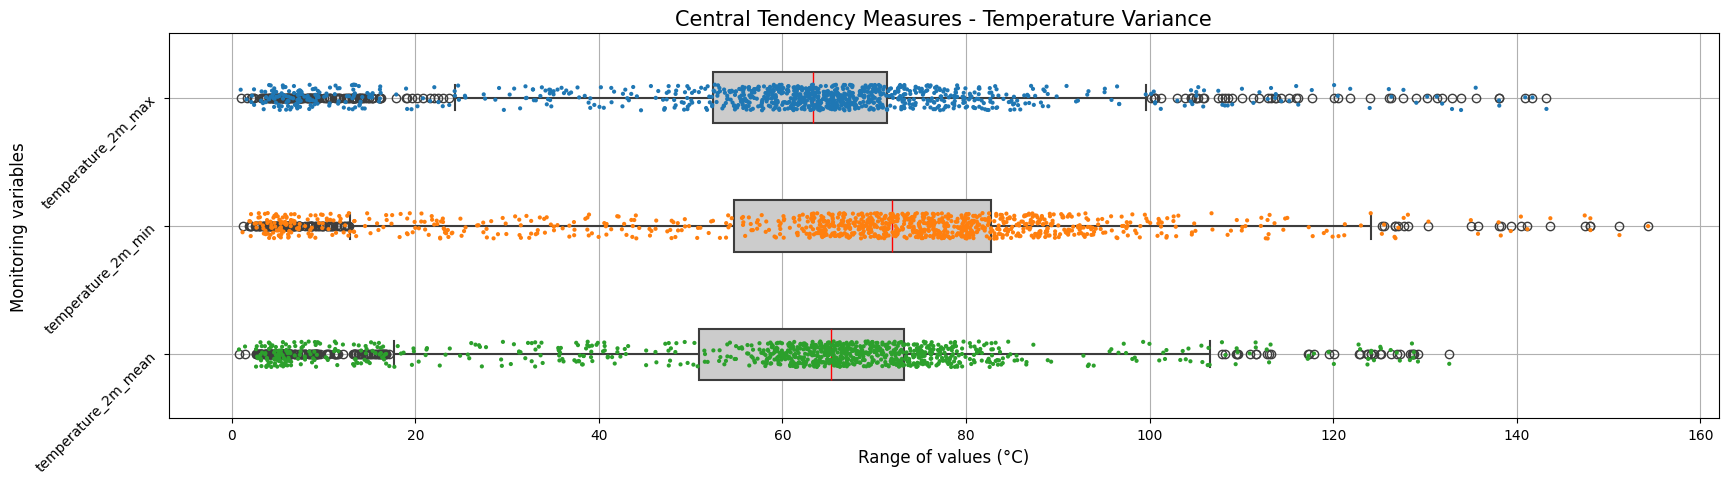

In [ ]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Variance",
    xlabel="°C"
    )

> Apparent Temperature

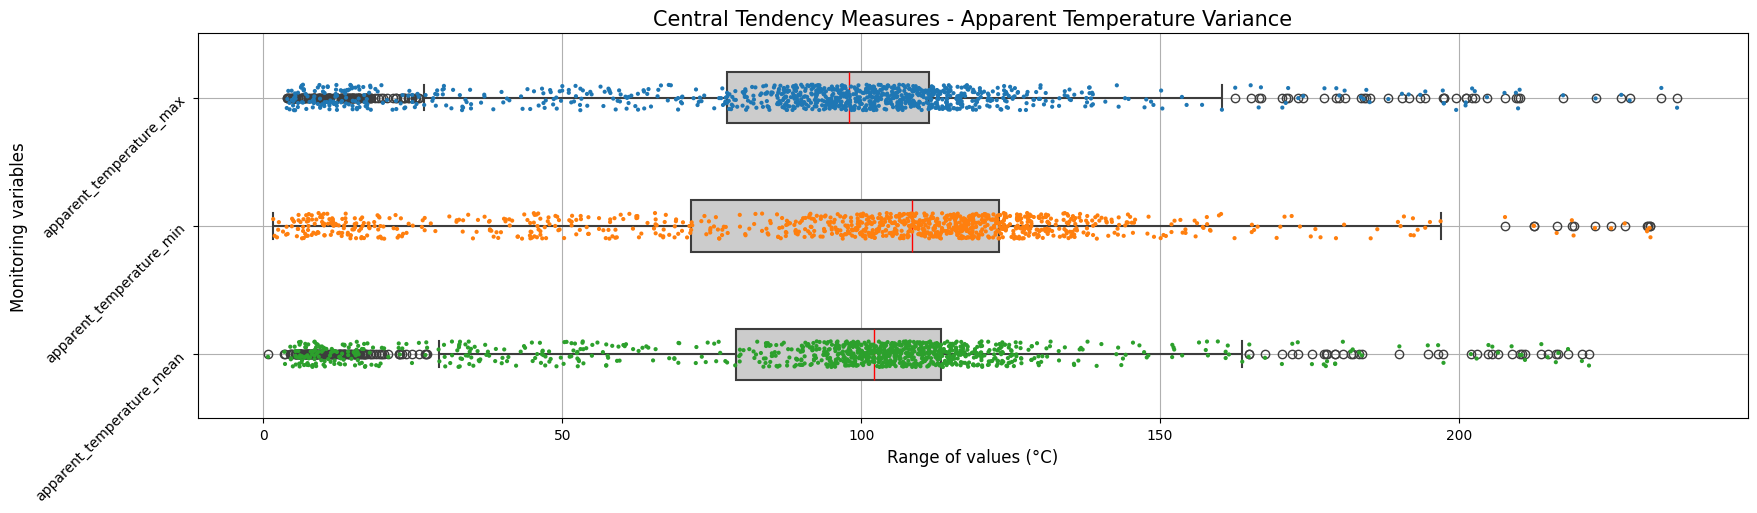

In [ ]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Variance",
    xlabel="°C"
    )

> Precipitation and rain

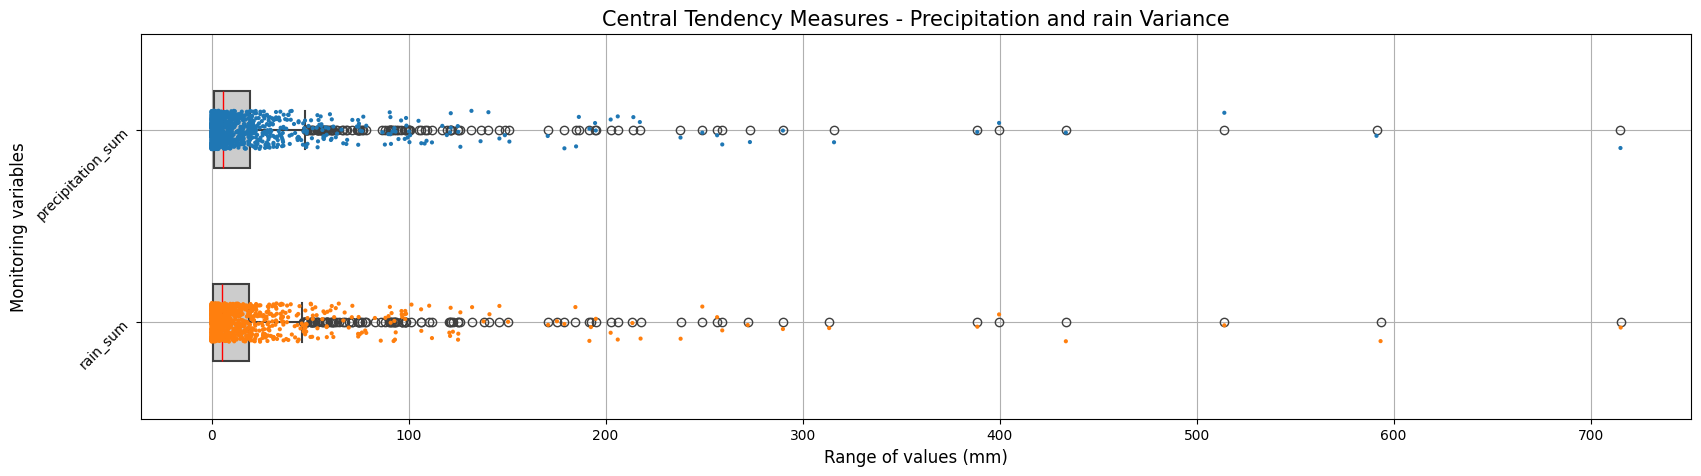

In [ ]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Variance",
    xlabel="mm"
    )

> Snowfall

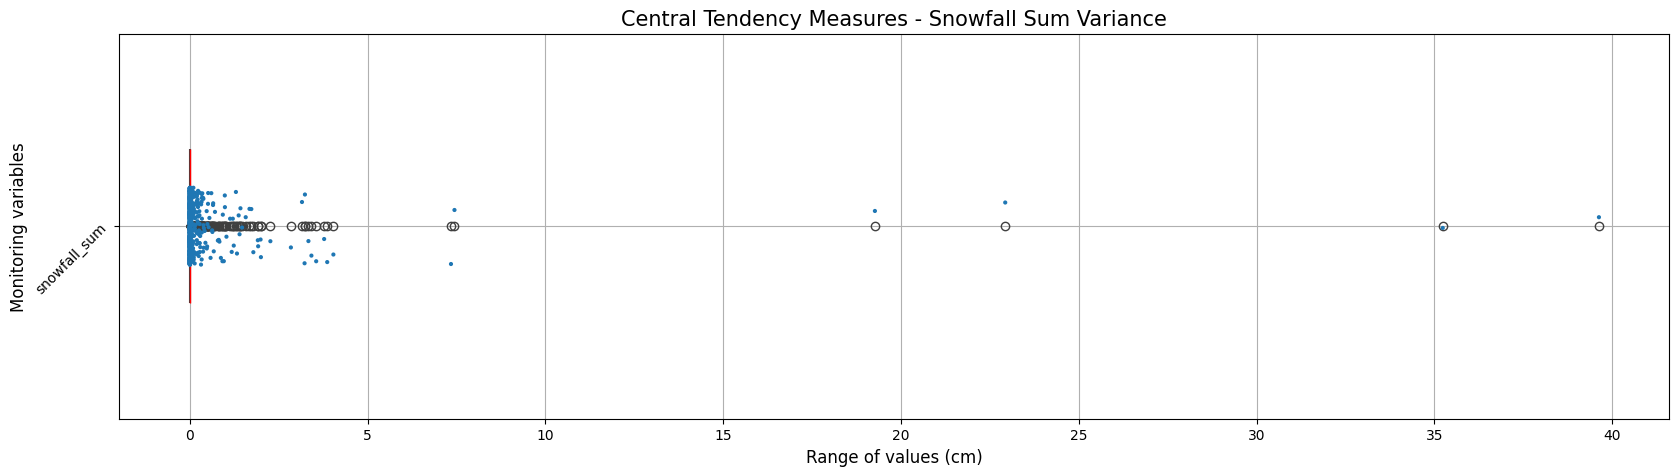

In [ ]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Variance",
    xlabel="cm"
    )

> Precipitation

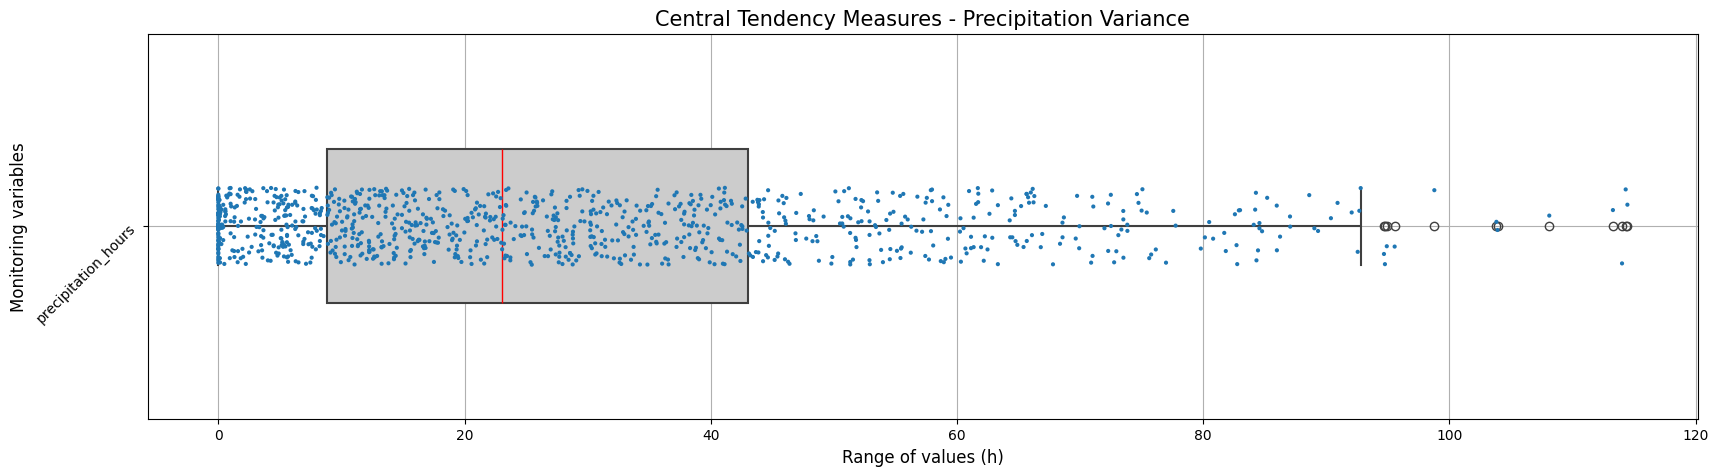

In [ ]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Variance",
    xlabel="h"
    )

> Wind speed 10m

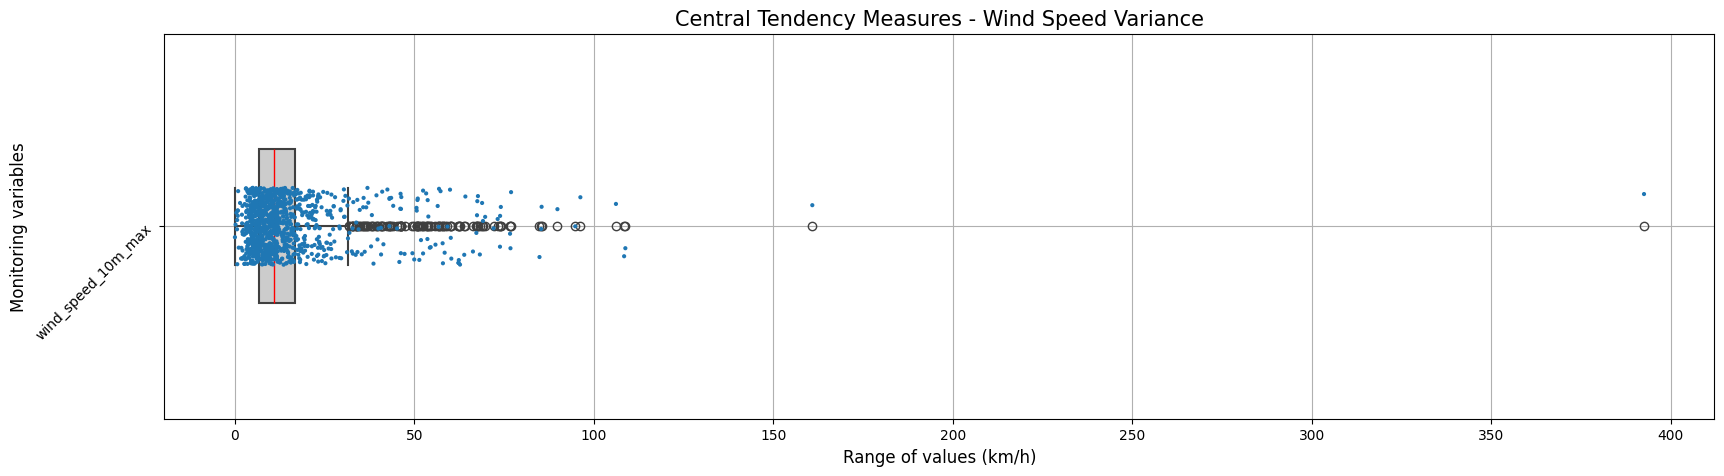

In [ ]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Variance",
    xlabel="km/h"
    )

> Wind direction 10m

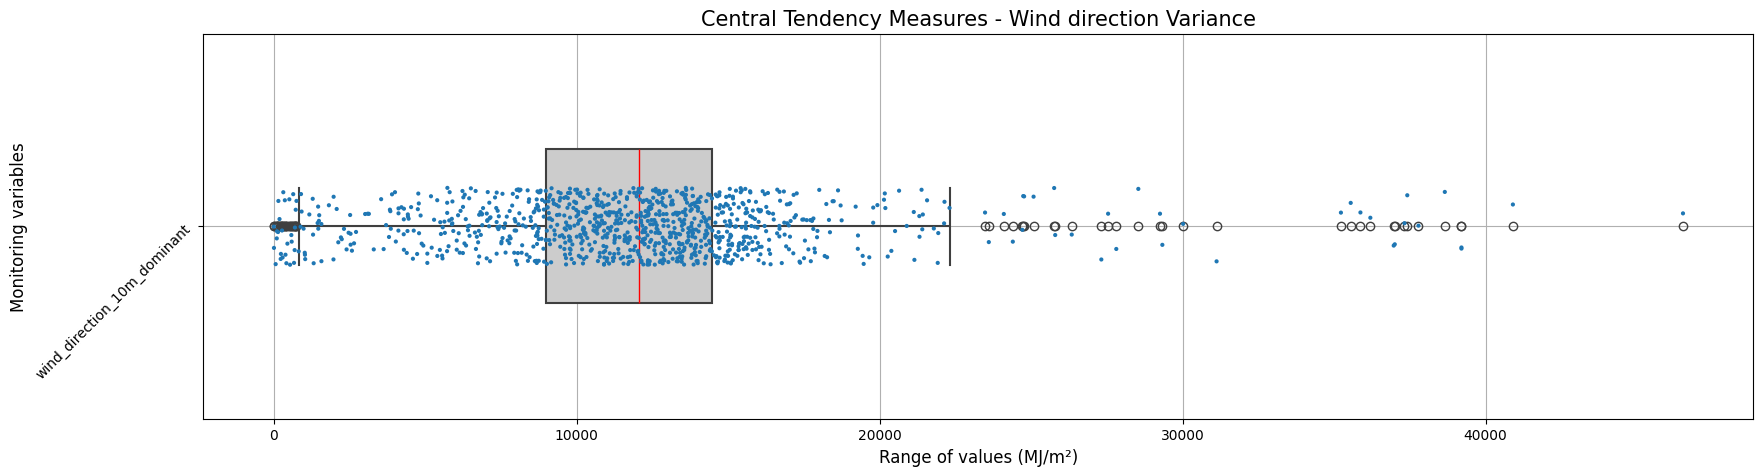

In [ ]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Variance",
    xlabel="MJ/m²"
    )

> Shortwave radiation

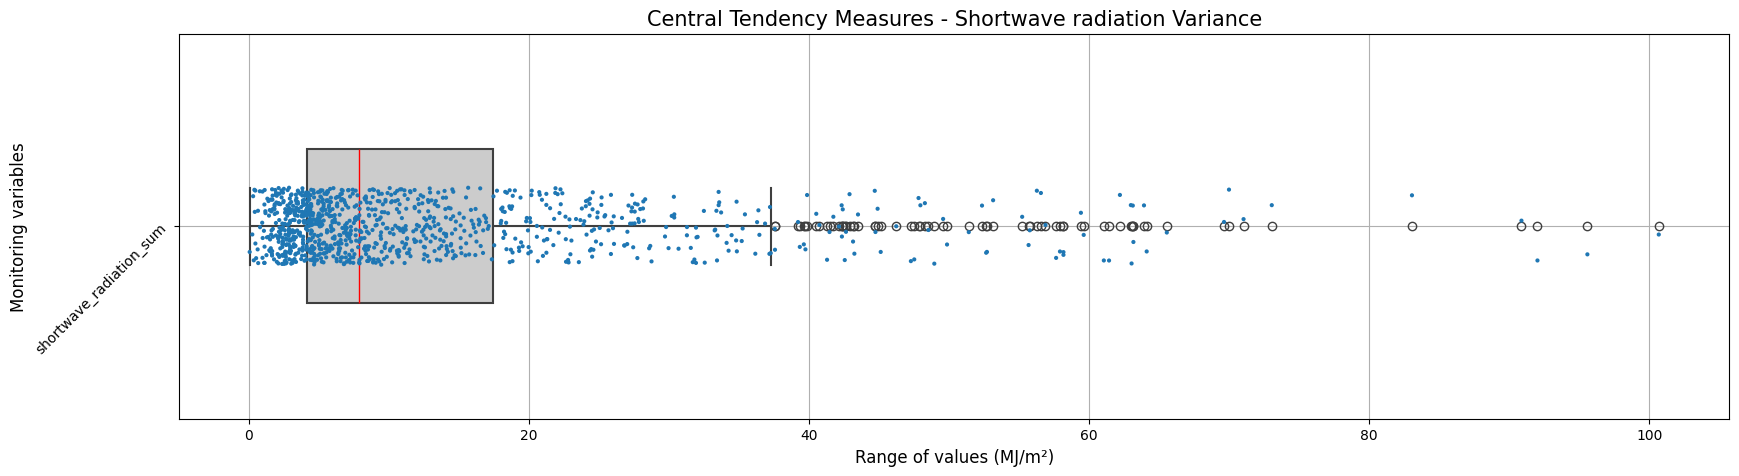

In [ ]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Variance",
    xlabel="MJ/m²"
    )

> Evapotranspiration

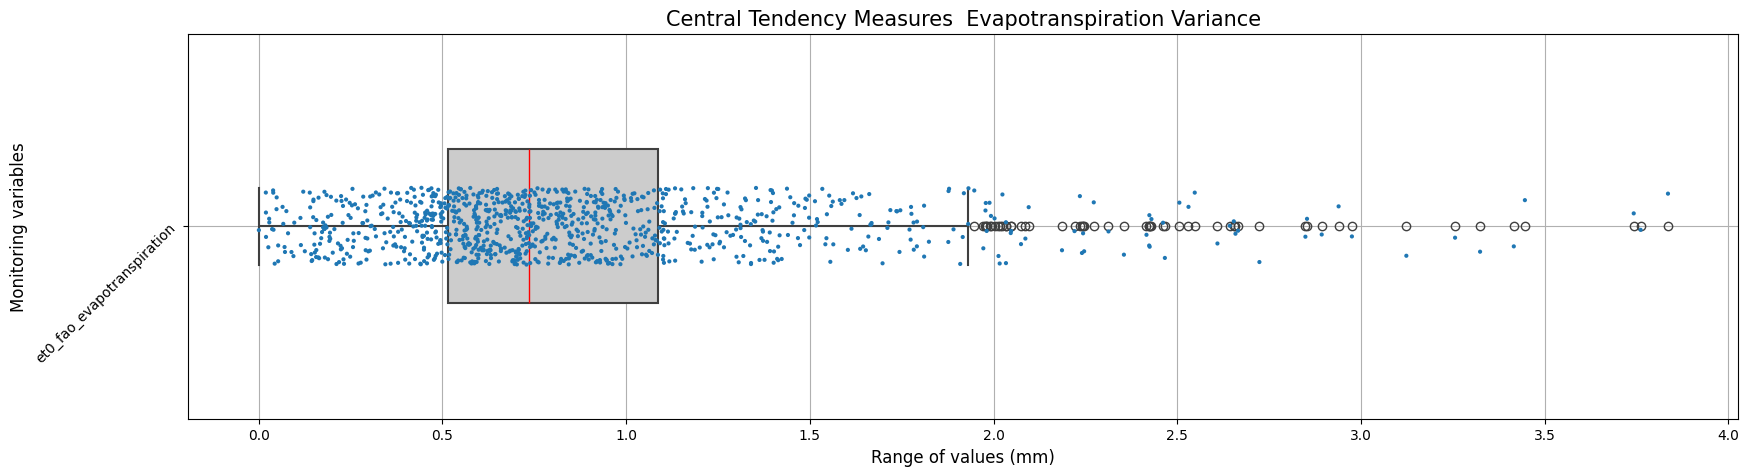

In [ ]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures  Evapotranspiration Variance",
    xlabel="mm"
    )

## Standard Deviation

In [ ]:
_data = df.groupby(['time']).std(ddof=0)
display(_data)

temperature_2m_max  temperature_2m_min  temperature_2m_mean  \
time                                                                      
2000-06-17            3.044485            5.354334             4.246044   
2000-07-01            3.621313            4.509006             3.896969   
2000-07-02            3.528664            3.548087             3.316758   
2000-07-03            3.790970            3.809323             3.289367   
2000-07-04            2.367181            3.872990             2.897788   
...                        ...                 ...                  ...   
2015-09-26            7.574701            7.910145             7.720628   
2015-09-27            7.340736            8.176974             7.504692   
2015-09-28            7.916413            7.194449             7.434622   
2015-09-29            7.428062            7.618064             7.310103   
2015-09-30            7.212136            7.980451             7.364163   

            apparent_temperature_max  apparent_temperature_min  \
time                                                             
2000-06-17                  3.395095                  5.638755   
2000-07-01                  3.745660                  5.625604   
2000-07-02                  4.324273                  4.330348   
2000-07-03                  4.454301                  4.572551   
2000-07-04                  3.580657                  4.685505   
...                              ...                       ...   
2015-09-26                  9.588973                  9.293659   
2015-09-27                  8.888245                  9.380000   
2015-09-28                  9.320735                  8.343524   
2015-09-29                  8.856207                  8.664323   
2015-09-30                  8.728001                  8.949575   

            apparent_temperature_mean  precipitation_sum   rain_sum  \
time                                                                  
2000-06-17                   4.502839           0.471405   0.471405   
2000-07-01                   4.629461           1.736475   1.736475   
2000-07-02                   4.449159           8.624153   8.624153   
2000-07-03                   4.132505          13.670221  13.595590   
2000-07-04                   3.810097           0.022330   0.022330   
...                               ...                ...        ...   
2015-09-26                   9.438755           5.222921   5.130263   
2015-09-27                   9.009889           6.272711   6.272711   
2015-09-28                   8.999533           4.244867   4.191957   
2015-09-29                   8.698419           3.791781   3.791781   
2015-09-30                   8.676405           5.927605   5.913239   

            snowfall_sum  precipitation_hours  wind_speed_10m_max  \
time                                                                
2000-06-17      0.000000             2.357023            4.414370   
2000-07-01      0.000000             2.220529            5.579811   
2000-07-02      0.000000             2.148245            7.367346   
2000-07-03      0.137171             7.460188            5.722704   
2000-07-04      0.000000             0.223297            2.351778   
...                  ...                  ...                 ...   
2015-09-26      0.270113             8.111720            3.153807   
2015-09-27      0.000000             7.068239            3.058905   
2015-09-28      0.126000             6.797794            2.199000   
2015-09-29      0.000000             5.158488            2.240893   
2015-09-30      0.189000             7.282857            2.949305   

            wind_gusts_10m_max  wind_direction_10m_dominant  \
time                                                          
2000-06-17            6.048691                    26.089589   
2000-07-01            8.517800                    97.207349   
2000-07-02           11.984810                   122.043383   
2000-07-03           11.612348          

### Data visualization with processing

> Temperature

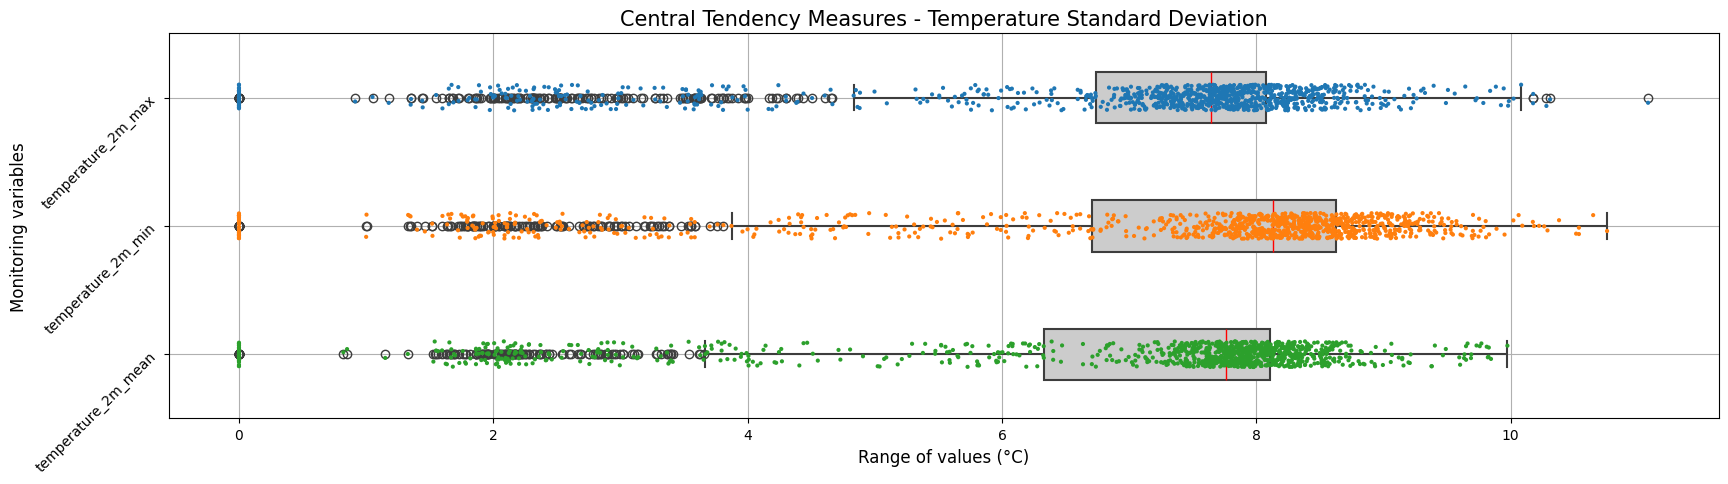

In [ ]:
generate_bsplot(
    dataTable=_data[['temperature_2m_max', 'temperature_2m_min', 'temperature_2m_mean']],
    title="Central Tendency Measures - Temperature Standard Deviation",
    xlabel="°C"
    )

> Apparent Temperature

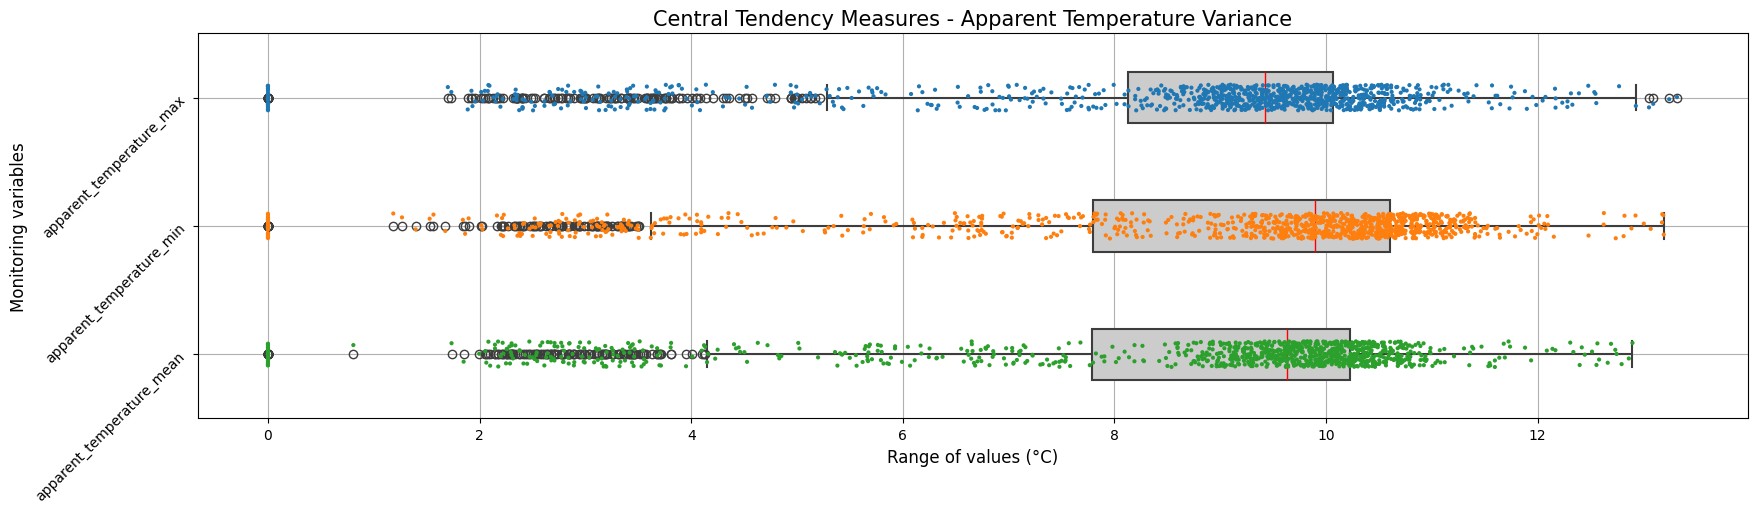

In [ ]:
generate_bsplot(
    dataTable=_data[['apparent_temperature_max', 'apparent_temperature_min', 'apparent_temperature_mean']],
    title="Central Tendency Measures - Apparent Temperature Variance",
    xlabel="°C"
    )

> Precipitation and rain

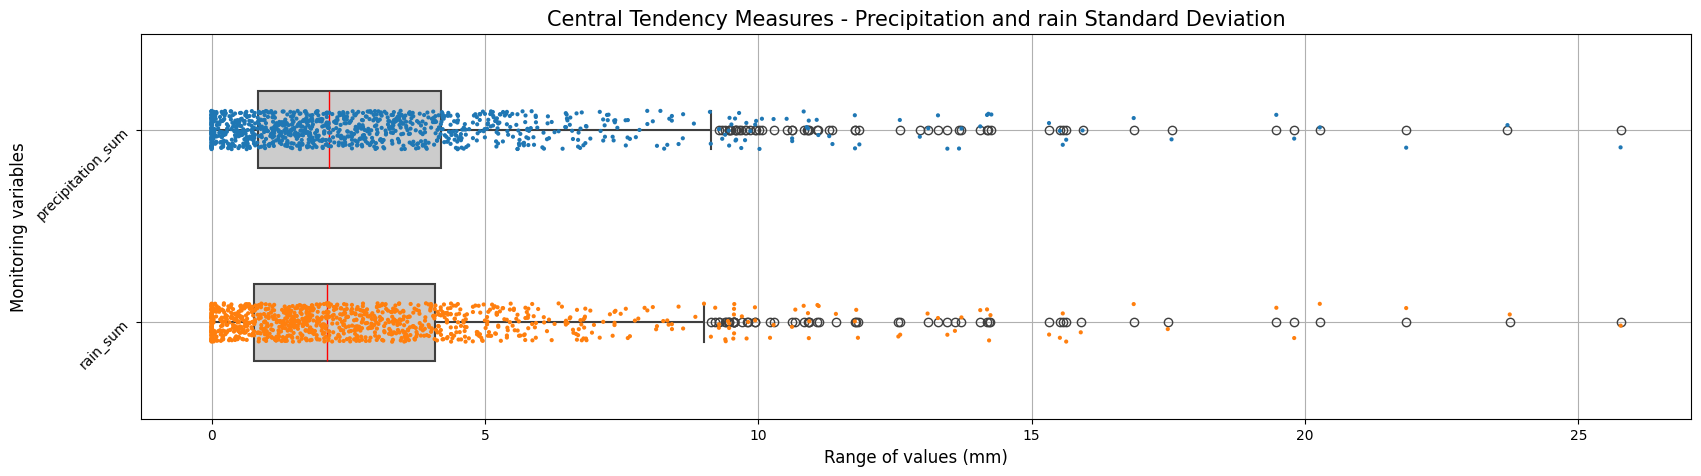

In [ ]:
generate_bsplot(
    dataTable=_data[['precipitation_sum', 'rain_sum']],
    title="Central Tendency Measures - Precipitation and rain Standard Deviation",
    xlabel="mm"
    )

> Snowfall

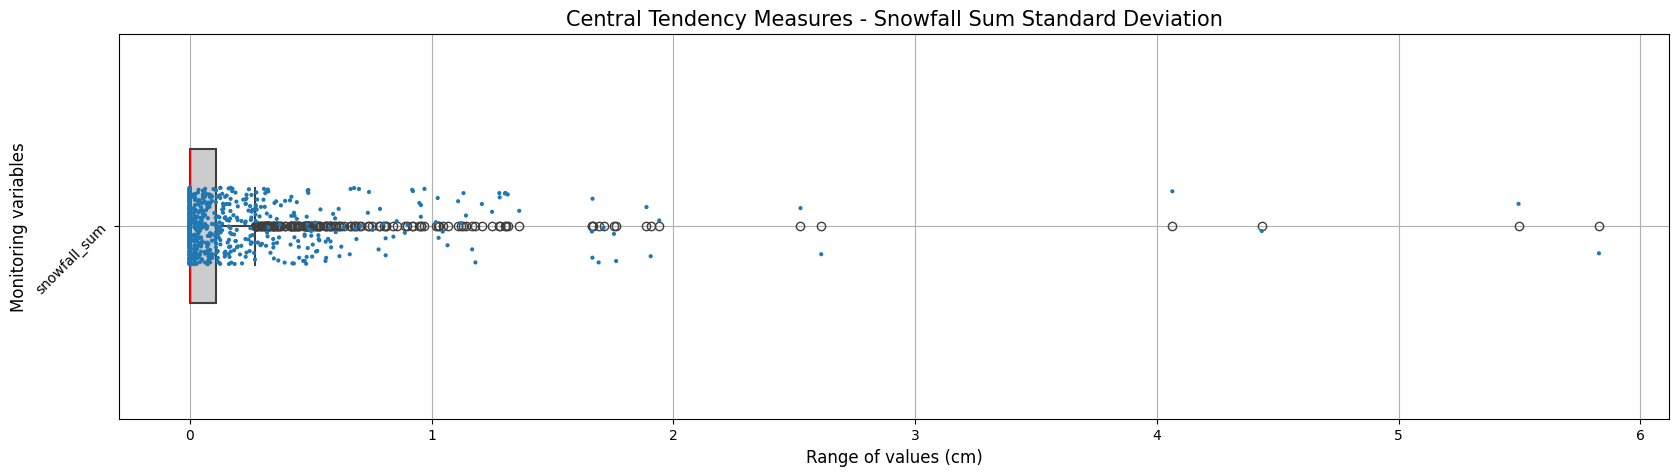

In [ ]:
generate_bsplot(
    dataTable=_data[['snowfall_sum']],
    title="Central Tendency Measures - Snowfall Sum Standard Deviation",
    xlabel="cm"
    )

> Precipitation

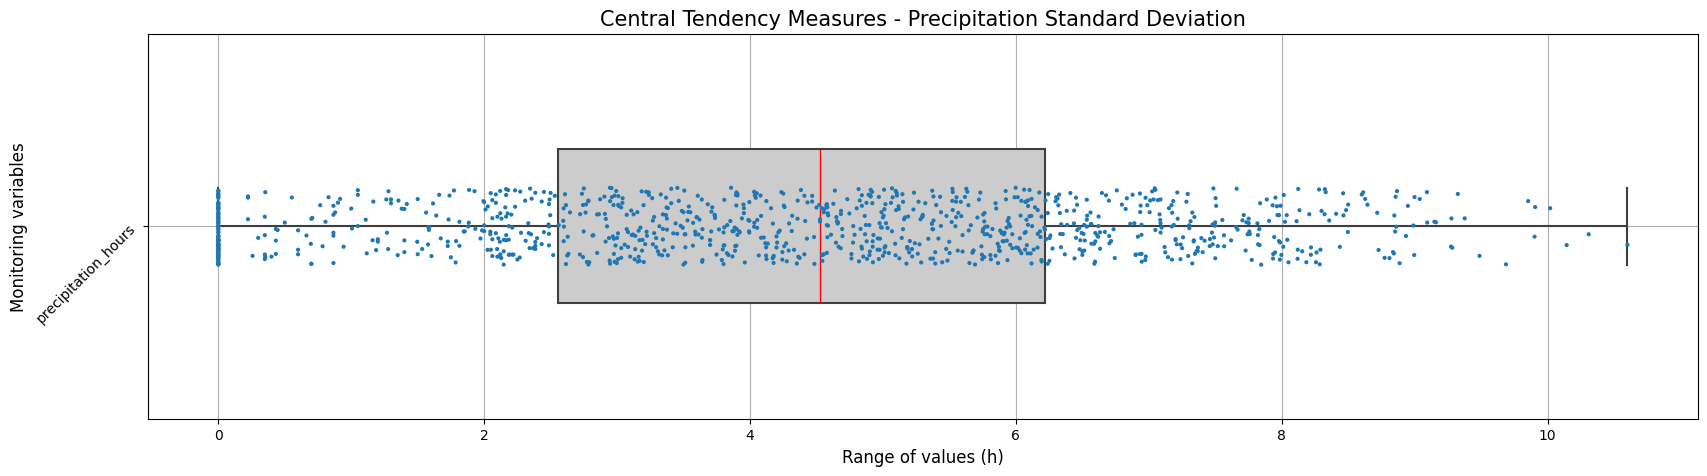

In [ ]:
generate_bsplot(
    dataTable=_data[['precipitation_hours']],
    title="Central Tendency Measures - Precipitation Standard Deviation",
    xlabel="h"
    )

> Wind speed 10m

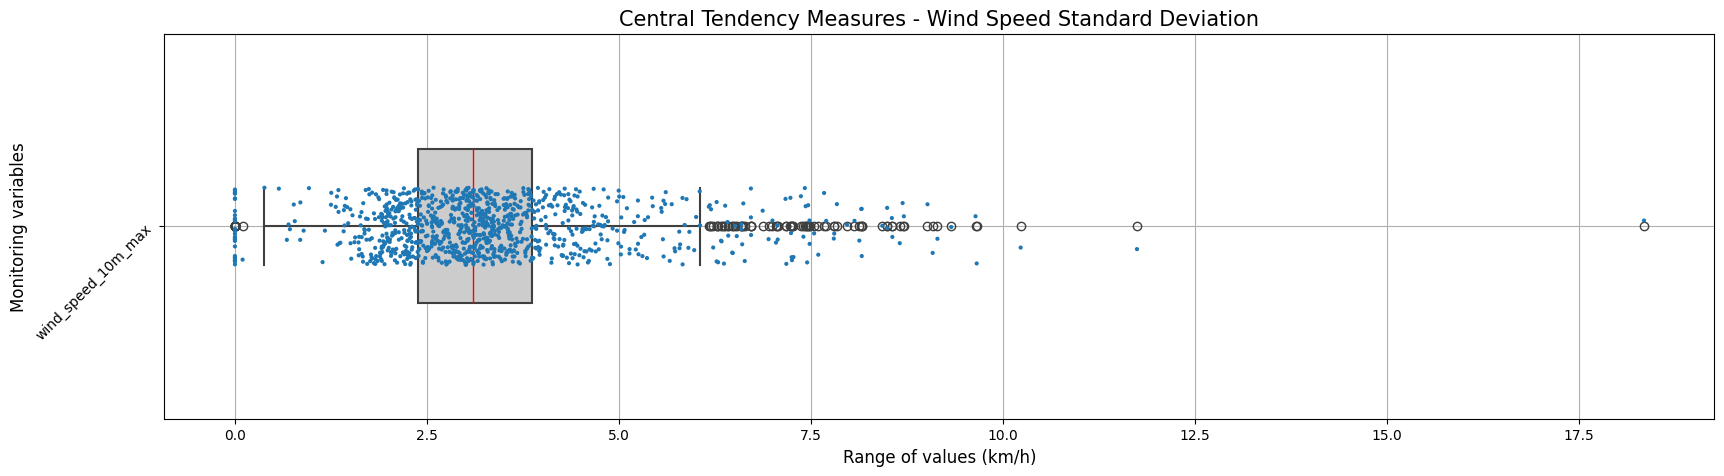

In [ ]:
generate_bsplot(
    dataTable=_data[['wind_speed_10m_max']],
    title="Central Tendency Measures - Wind Speed Standard Deviation",
    xlabel="km/h"
    )

> Wind direction 10m

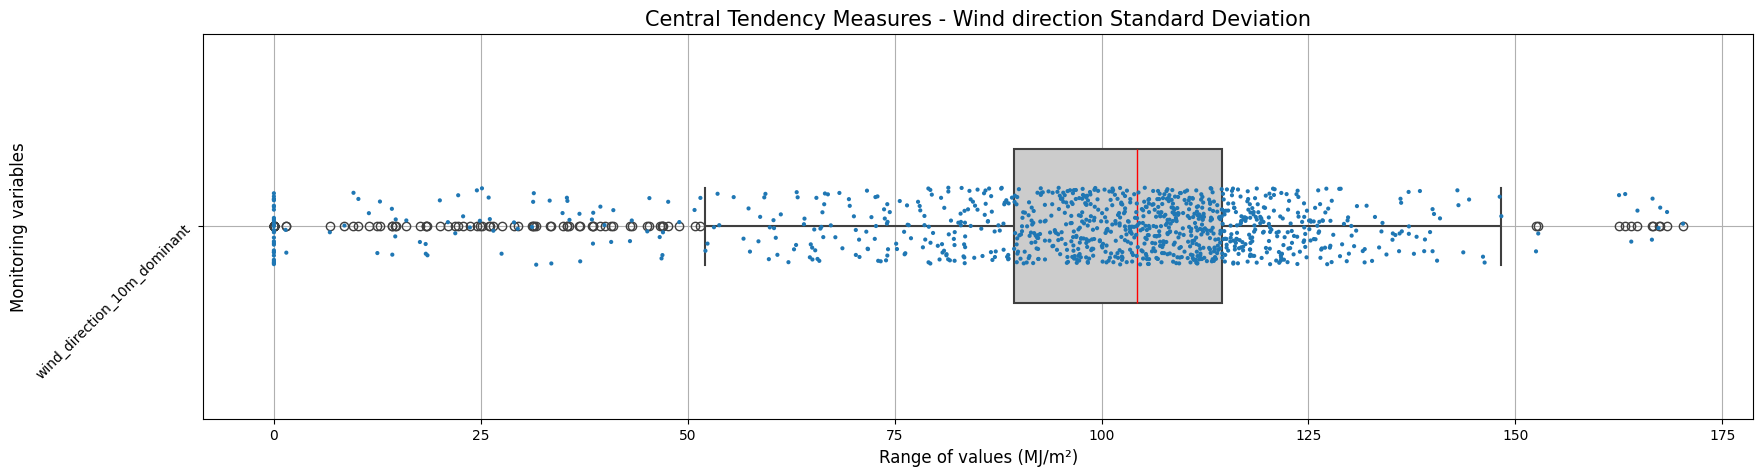

In [ ]:
generate_bsplot(
    dataTable=_data[['wind_direction_10m_dominant']],
    title="Central Tendency Measures - Wind direction Standard Deviation",
    xlabel="MJ/m²"
    )

> Shortwave radiation

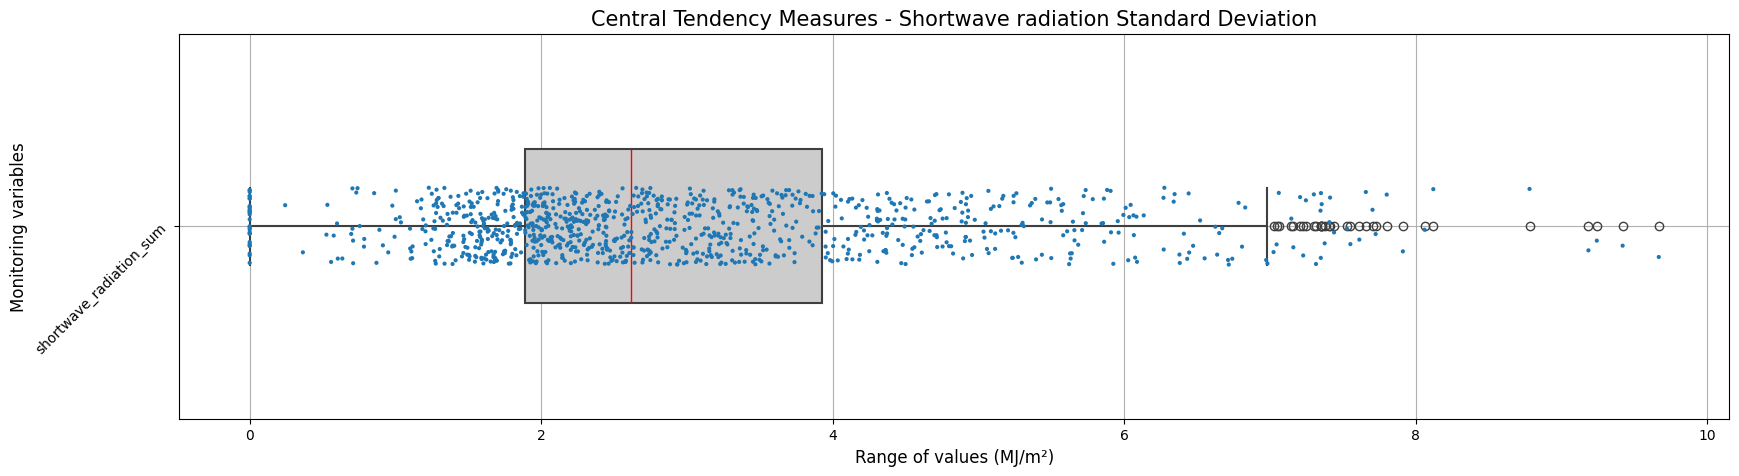

In [ ]:
generate_bsplot(
    dataTable=_data[['shortwave_radiation_sum']],
    title="Central Tendency Measures - Shortwave radiation Standard Deviation",
    xlabel="MJ/m²"
    )

> Evapotranspiration

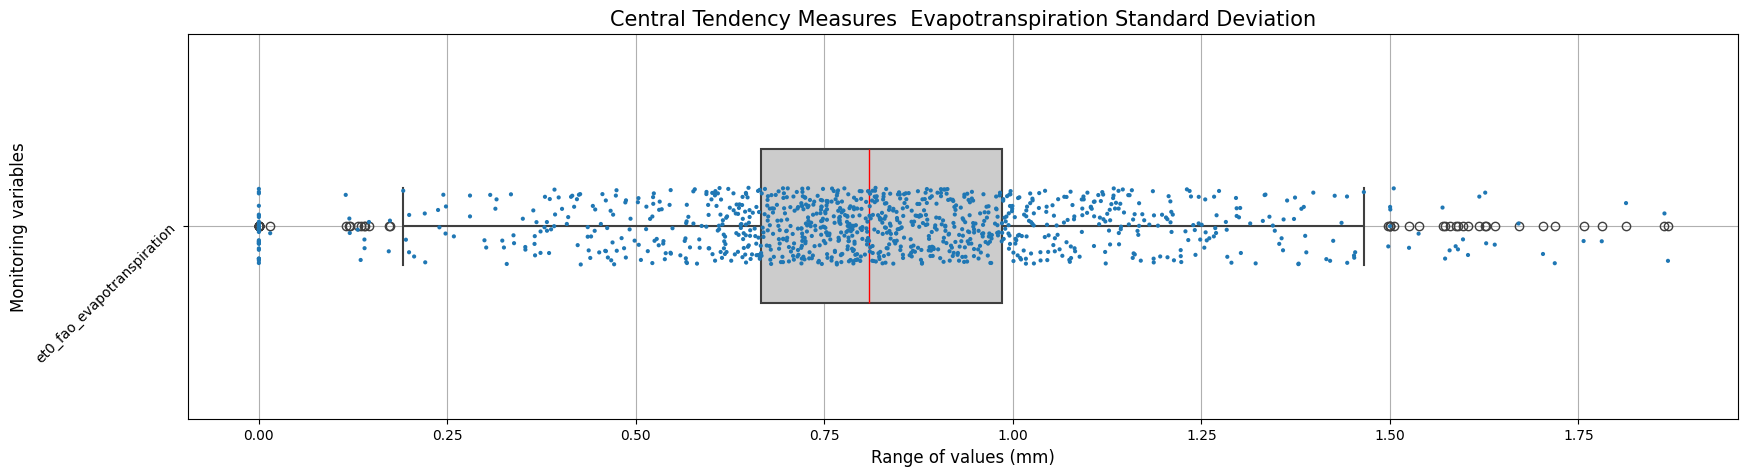

In [ ]:
generate_bsplot(
    dataTable=_data[['et0_fao_evapotranspiration']],
    title="Central Tendency Measures  Evapotranspiration Standard Deviation",
    xlabel="mm"
    )

## Covariance

In [ ]:
_data = df.groupby(['time']).mean().cov()
display(_data)

temperature_2m_max  temperature_2m_min  \
temperature_2m_max                     8.132419            7.436915   
temperature_2m_min                     7.436915           11.599807   
temperature_2m_mean                    7.727914            9.401416   
apparent_temperature_max              10.692097           11.710156   
apparent_temperature_min               9.655273           15.499628   
apparent_temperature_mean             10.047871           13.288062   
precipitation_sum                     -0.909037            2.319479   
rain_sum                              -0.689549            2.470238   
snowfall_sum                          -0.158066           -0.108574   
precipitation_hours                   -1.232957            3.807239   
wind_speed_10m_max                    -2.596635           -3.295284   
wind_gusts_10m_max                    -1.588274           -0.312459   
wind_direction_10m_dominant          -32.046422          -37.605050   
shortwave_radiation_sum                4.512998            3.054637   
et0_fao_evapotranspiration             1.133151            0.784084   

                             temperature_2m_mean  apparent_temperature_max  \
temperature_2m_max                      7.727914                 10.692097   
temperature_2m_min                      9.401416                 11.710156   
temperature_2m_mean                     8.548183                 11.103248   
apparent_temperature_max               11.103248                 15.561513   
apparent_temperature_min               12.402125                 15.728786   
apparent_temperature_mean              11.616104                 15.291059   
precipitation_sum                       0.585245                  0.488149   
rain_sum                                0.778429                  0.759570   
snowfall_sum                           -0.139064                 -0.196138   
precipitation_hours                     1.099300                  1.106988   
wind_speed_10m_max                     -3.038588                 -4.814741   
wind_gusts_10m_max                     -1.055186                 -3.062863   
wind_direction_10m_dominant           -35.260902                -41.789743   
shortwave_radiation_sum                 3.883665                  7.022066   
et0_fao_evapotranspiration              0.974559                  1.600454   

                             apparent_temperature_min  \
temperature_2m_max                           9.655273   
temperature_2m_min                          15.499628   
temperature_2m_mean                         12.402125   
apparent_temperature_max                    15.728786   
apparent_temperature_min                    21.093144   
apparent_temperature_mean                   17.924338   
precipitation_sum                            3.394421   
rain_sum                                     3.580696   
snowfall_sum                                -0.134304   
precipitation_hours                          5.788633   
wind_speed_10m_max                          -5.145957   
wind_gusts_10m_max                          -1.335749   
wind_direction_10m_dominant                -50.465157   
shortwave_radiation_sum                      4.386546   
et0_fao_evapotranspiration                   1.041935   

                             apparent_temperature_mean  precipitation_sum  \
temperature_2m_max                           10.047871          -0.909037   
temperature_2m_min                           13.288062           2.319479   
temperature_2m_mean                          11.616104           0.585245   
apparent_temperature_max                     15.291059           0.488149   
apparent_temperature_min                     17.924338           3.394421   
apparent_temperature_mean                    16.325731           1.629646   
precipitation_sum                             1.629646           6.495664   
rain_sum                                      1.867214           6.340646   
snowfall_sum                         

### Data visualization with processing

> Temperature

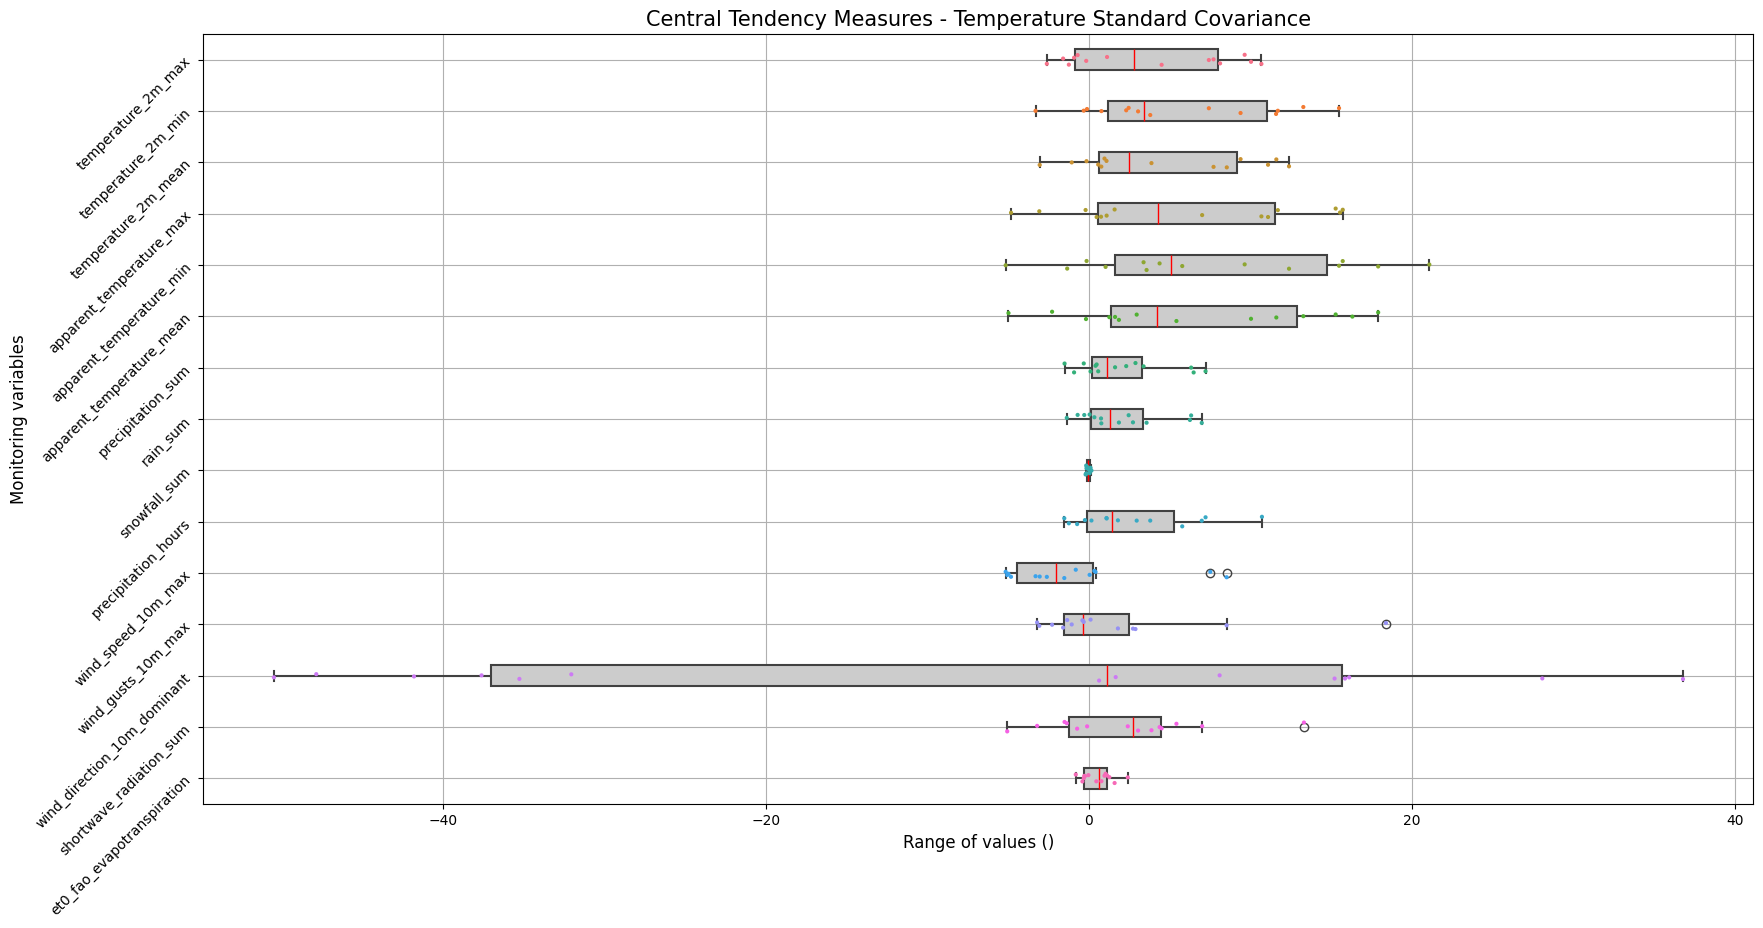

In [ ]:
generate_bsplot(
    dataTable=_data.query("wind_direction_10m_dominant < 2500"),
    title="Central Tendency Measures - Temperature Standard Covariance",
    xlabel="",
    width=20,
    heigth=10
    )

##Correlation

In [ ]:
_data = df.groupby(['time']).mean().corr()
display(_data)

temperature_2m_max  temperature_2m_min  \
temperature_2m_max                     1.000000            0.765698   
temperature_2m_min                     0.765698            1.000000   
temperature_2m_mean                    0.926863            0.944128   
apparent_temperature_max               0.950445            0.871588   
apparent_temperature_min               0.737198            0.990890   
apparent_temperature_mean              0.872023            0.965606   
precipitation_sum                     -0.125072            0.267210   
rain_sum                              -0.096599            0.289754   
snowfall_sum                          -0.275693           -0.158560   
precipitation_hours                   -0.132021            0.341342   
wind_speed_10m_max                    -0.331826           -0.352596   
wind_gusts_10m_max                    -0.129821           -0.021384   
wind_direction_10m_dominant           -0.221998           -0.218123   
shortwave_radiation_sum                0.433510            0.245685   
et0_fao_evapotranspiration             0.580560            0.336361   

                             temperature_2m_mean  apparent_temperature_max  \
temperature_2m_max                      0.926863                  0.950445   
temperature_2m_min                      0.944128                  0.871588   
temperature_2m_mean                     1.000000                  0.962692   
apparent_temperature_max                0.962692                  1.000000   
apparent_temperature_min                0.923610                  0.868158   
apparent_temperature_mean               0.983303                  0.959346   
precipitation_sum                       0.078540                  0.048553   
rain_sum                                0.106365                  0.076923   
snowfall_sum                           -0.236578                 -0.247304   
precipitation_hours                     0.114811                  0.085688   
wind_speed_10m_max                     -0.378743                 -0.444792   
wind_gusts_10m_max                     -0.084124                 -0.180980   
wind_direction_10m_dominant            -0.238252                 -0.209278   
shortwave_radiation_sum                 0.363872                  0.487621   
et0_fao_evapotranspiration              0.487013                  0.592770   

                             apparent_temperature_min  \
temperature_2m_max                           0.737198   
temperature_2m_min                           0.990890   
temperature_2m_mean                          0.923610   
apparent_temperature_max                     0.868158   
apparent_temperature_min                     1.000000   
apparent_temperature_mean                    0.965909   
precipitation_sum                            0.289990   
rain_sum                                     0.311468   
snowfall_sum                                -0.145450   
precipitation_hours                          0.384866   
wind_speed_10m_max                          -0.408324   
wind_gusts_10m_max                          -0.067793   
wind_direction_10m_dominant                 -0.217071   
shortwave_radiation_sum                      0.261635   
et0_fao_evapotranspiration                   0.331466   

                             apparent_temperature_mean  precipitation_sum  \
temperature_2m_max                            0.872023          -0.125072   
temperature_2m_min                            0.965606           0.267210   
temperature_2m_mean                           0.983303           0.078540   
apparent_temperature_max                      0.959346           0.048553   
apparent_temperature_min                      0.965909           0.289990   
apparent_temperature_mean                     1.000000           0.158251   
precipitation_sum                             0.158251           1.000000   
rain_sum                                      0.184618           0.993890   
snowfall_sum                         

### Data visualization with processing

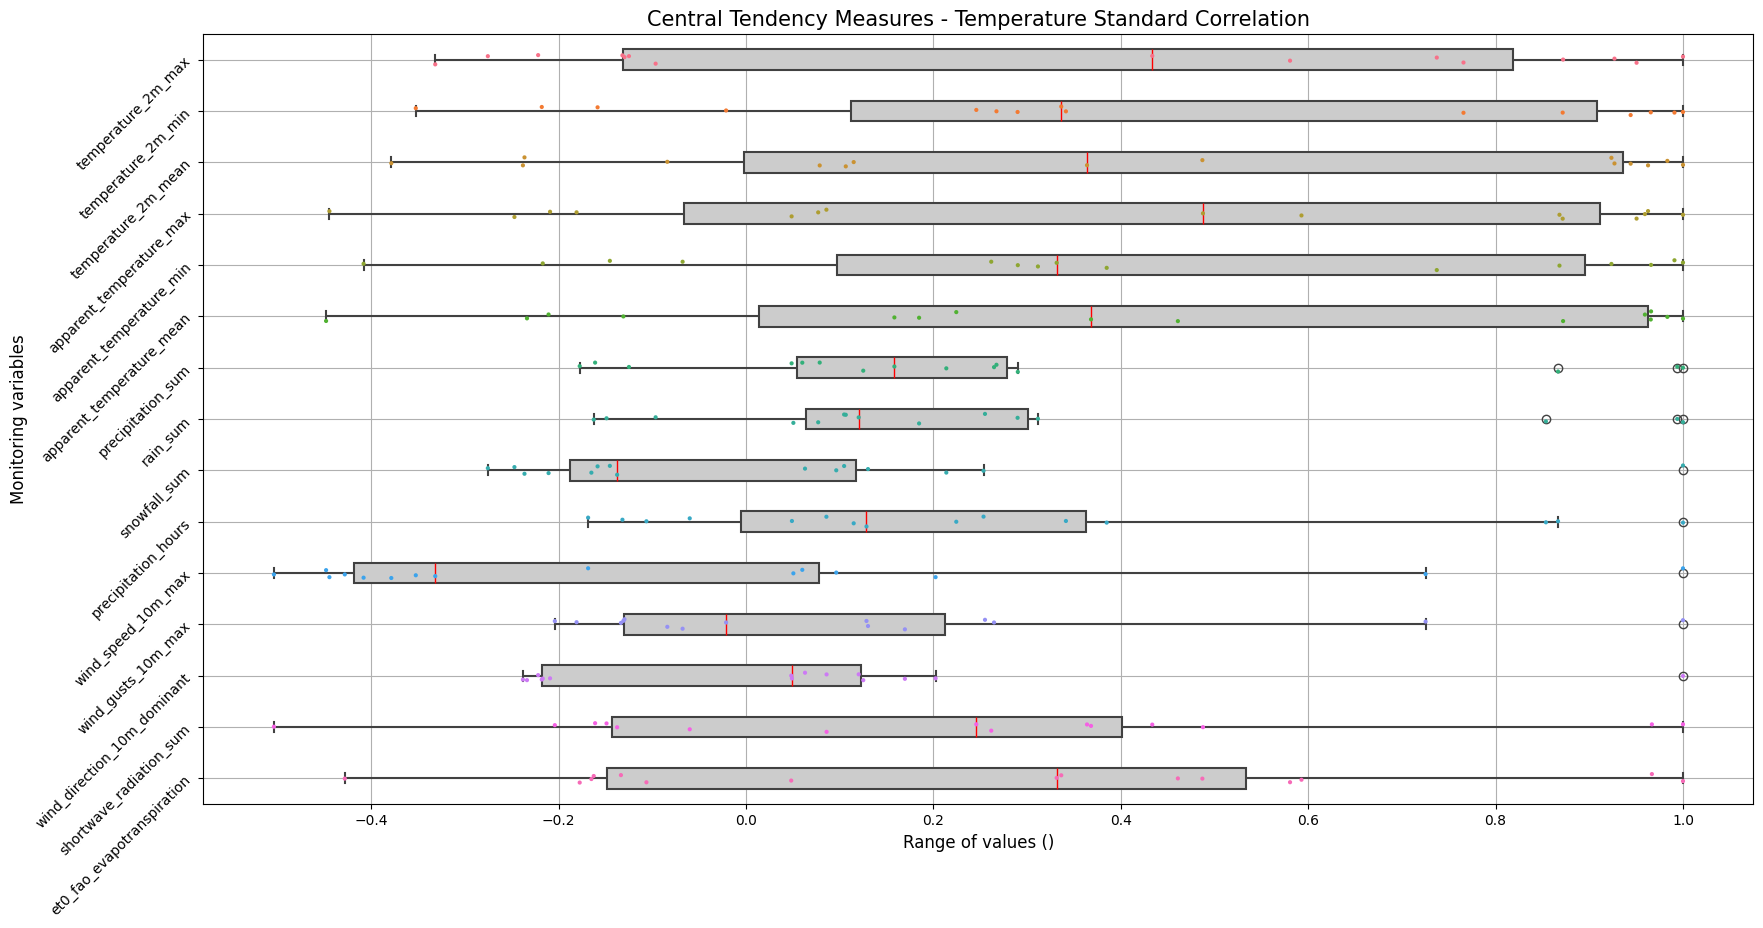

In [ ]:
generate_bsplot(
    dataTable=_data,
    title="Central Tendency Measures - Temperature Standard Correlation",
    xlabel="",
    width=20,
    heigth=10
    )